# Deskriptivna analiza

In [1]:
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install seaborn
#!pip3 install dython
#!pip3 install sklearn

In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from dython import nominal
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from math import log2

# Header columns za labled podatke
labledColums = ["Uporabnik", "Starost", "Spol", "Extraversion", "Agreeableness", "Conscientiousness", "Emotional Stability", 
                "Openness to new Experiences", "Ime oglasa", "Vrsta oglasa", "Uporabniška aktivnost", 
                "Nivo baterije", "Trajanje oglasa", "Internetna povezava", "Svetlost zaslona", "Ura", 
                "Lokacija", "Odgovor 1 Pravilen", "Odgovor 2 Pravilen", "Ocena prikaza oglasa"]


# Header columns za vse podatke oziroma unlabled
allColums = ["Uporabnik", "Starost", "Spol", "Extraversion", "Agreeableness", "Conscientiousness", "Emotional Stability", 
             "Openness to new Experiences", "Ime oglasa", "Vrsta oglasa", "Uporabniška aktivnost", 
                "Nivo baterije", "Trajanje oglasa", "Internetna povezava", "Svetlost zaslona", "Ura", 
                "Lokacija"]

labledVideoColumns = ["Uporabnik", "Starost", "Spol", "Ime oglasa", "Vrsta oglasa", "Uporabniška aktivnost", 
                "Nivo baterije", "Trajanje oglasa", "Trajanje oglasa%", "Internetna povezava", "Svetlost zaslona", "Ura", 
                "Lokacija", "Odgovor 1 Pravilen", "Odgovor 2 Pravilen", "Ocena prikaza oglasa"]

dfUnlabled = pd.read_csv("data/noFeedback.csv", header=None, names=allColums, delimiter=';')
dfLabled = pd.read_csv("data/feedbackOnly.csv", header=None, names=labledColums, delimiter=';')
dfVideoLabled = pd.read_csv("data/videoFeedbackOnly.csv", header=None, names=labledVideoColumns, delimiter=';')
dfAll = pd.read_csv("data/headerGeneric.csv", header=None, names=labledColums, delimiter=';')

ocene = [-2, -1, 0, 1, 2]

print("Unlabled data: ", len(dfUnlabled))
print("Labled data:   ", len(dfLabled))
print("All data:      ", len(dfAll))

Unlabled data:  493
Labled data:    501
All data:       994


Predno začnemo z zbiranjem podatkov moramo poskrbeti za dobro uporabniško izkušnjo in pravilno delovanje. 
Aplikacija je v prvi iteraciji bila testirana s strani razvijalca. Namen prvotnih testov je preveriti delovanje 
funkcionalnosti in njihovo obnašanje v različnih okoliščinah. Čeprav smo se osredotočili na platformo Android, 
obstaja mnogo mobilnih naprav različnih proizvajalcev, na katerih aplikacija Studentko lahko povzroči nepredvideno
obnašanje.

Prvi fazi testiranja sledi pilotna študija. Njen namen je ugotoviti, ali funkcionalnosti aplikacije ustrezno delujejo ter odpraviti nezaželjeno obnašanje. Poleg tega smo s pilotno študijo določili čas pojavitve vprašalnika in število akcij potrebnih za prikaz oglasa. Z nami so sodelovale tri osebe. Testiranje je trajalo približno en teden. S pomočjo tesne komunikacije smo odpravili odkrite napake, prilagodili izgled aplikacije in izboljšali uporabniško izkušnjo z manjšimi tekstovnimi popravki. Z zaključkom pilotne študije je aplikacija bila pripravljena na uporabo. 

V nadaljni raziskavi je sodelovalo štirinajst ljudi, pri čemer je bilo dvanajst oseb moškega spola in dve ženskega. Povprečna starost vseh udeležencev je bila 27 let. Zbranih je bilo 994 različnih vnosov.

Čeprav aplikacija vsebuje kratek vodič, ki na kratko predstavi ključne funkcionalnosti in cilj diplome, je vsak udeleženec prejel še dokument v PDF obliki. Ta je vseboval dodatna pojasnila, glede shranjevanja in pridobivanja uporabniških informacij.

Raziskava je trajala dva meseca in je potekala v obdobju koronavirus pandemije. Zaradi raznih ukrepov, ki jih je sprejela vlada Republike Slovenije in spremenjenega načina vsakodnevnega življenja udeležencev, so bile nekatere vrednosti podatkov zavržene, saj je število njihovih pojavitev bilo preredko. Tako smo opustili vse vnose, ki so imeli uporabniško aktivnost vožnje in lokacijo, ki je predstavljala oznako delovnega mesta. Poleg samih vrednosti podatkov so uporabniki prejeli natančna navodila za registracijo, saj je zaradi omejenega gibanja odpadel eden izmed načinov klasifikacije lokacije.

**Naš kontekst so sestavljali sledeči parametri:**

* Trenutna uporabniška aktivnost (zaradi koronavirus pandemije smo ohranili le podatke, ko je uporabnik pri miru ali pa v stanju gibanja),
* Nivo baterije mobilne naprave (vrednost se nahaja na intervalu med [0, 1]),
* Vrsta internetne povezave (predstavlja prenos podatkov preko mobilnega interneta oziroma brezžičnega omrežja),
* Svetlost zaslona (vrednost je zajeta na intervalu med [0, 255]),
* Čas, ko si je uporabnik pogledal oglas (zabeleži se ura, ko je strežnik prejel podatke z mobilne naprave),
* Oznaka lokacije uporabnika (zaradi koronavirus pandemije smo opustili podatke, ki so označevali delovno mesto. Če se je uporabnik nahajal v okolici 300 metrov svojega doma smo mu dodelili oznako HOME, drugače pa se je v podatkovno bazo zabeležil vnos z oznako OTHER).

Poleg konteksta mobilne naprave smo beležili tudi druge podatke. Vsak vnos v podatkovno bazo je vseboval ime, vrsto in dolžino gledanja oglasa. Za boljše razumevanje podatkov smo v aplikacijo integrirali vprašalnik, ki se pojavi največ petkrat na dan. S tem smo želeli pridobiti nivo interakcije uporabnika z oglasom. Vprašalnik se lahko pojavi zgolj le dvakrat v roku treh ur. Z omejitvijo števila prikazanih vprašalnikov smo želeli izboljšati uporabniško izkušnjo, saj so druge študije pokazale, da prepogosto anketiranje povzroči manjšo uporabo aplikacij. V skrajnih primerih uporabniki lahko aplikacijo celo odstranijo. V našem primeru smo po dveh tednih odstranili omejitev prikaza vprašalnikov, saj udeleženci niso bili preobremenjeni z njegovim izpolnjevanjem.

**Kratek opis postopka zbiranja podatkov:**
1. Uporabnik dostopa do različnih funkcionalnosti aplikacije.
2. Določene uporabniške akcije se zabeležijo v shrambo mobilne naprave.
3. Ćez celotno izvajanje aplikacije se poslušajo spremembe parametrov konteksta.
4. Ko uporabnik izvede peto akcijo se mu na zaslon prikaže oglas.
5. Ob zaprtju okna z oglasom se na strežnik pošljejo podatki konteksta in čas trajanja oglasa.
6. Zaledni sistem si zabeleži uro prejetja podatkov in vse skupaj zapiše v podatkovno bazo. Uporabniku nato odgovori z enoličnim identifikatorjem vnešenih podatkov.
7. Po prejetju identifikatorja se uporabniku po eni sekundi prikaže kratek vprašalnik. 
8. Z izpolnitvijo vprašalnika se identifikator in uporabnikovi odgovori pošljejo nazaj na strežnik.

## Pregled in analiza uporabnikov

In [10]:
def user_analysis(df):
    uniqueUsers = df['Uporabnik'].unique()
    stVseh = len(df['Uporabnik'])    
    data = []
    
    for i, user in enumerate(uniqueUsers):
        userInputs = df.loc[(df['Uporabnik'] == user)]
        stVideoOgl = len(userInputs.loc[userInputs['Vrsta oglasa'] != 'image'])
        stSlikOgl = len(userInputs.loc[userInputs['Vrsta oglasa'] == 'image'])
        stOglasov = len(userInputs)
        medianS = userInputs['Ocena prikaza oglasa'].median()
        meanS = userInputs['Ocena prikaza oglasa'].mean()
        
        medianS_V = userInputs.loc[userInputs['Vrsta oglasa'] != 'image']['Ocena prikaza oglasa'].median()
        meanS_V = userInputs.loc[userInputs['Vrsta oglasa'] != 'image']['Ocena prikaza oglasa'].mean()
        
        medianS_I = userInputs.loc[userInputs['Vrsta oglasa'] == 'image']['Ocena prikaza oglasa'].median()
        meanS_I = userInputs.loc[userInputs['Vrsta oglasa'] == 'image']['Ocena prikaza oglasa'].mean()
        
        data.append([userInputs['Starost'].iloc[0], userInputs['Spol'].iloc[0], stOglasov, stOglasov / stVseh, stVideoOgl, stVideoOgl / stOglasov, stSlikOgl, stSlikOgl / stOglasov, meanS, medianS, meanS_V, medianS_V, meanS_I, medianS_I])
    
    dfUser = pd.DataFrame(data, columns = ['Age', 'Gender', '#Ads', '%Ads', '#Video', '%Video', '#Image', '%Image', 'S_Mean', 'S_Medain', 'S_Mean_Vid', 'S_Median_Vid', 'S_Mean_Img', 'S_Median_Img']) 
    return dfUser

In [11]:
def user_bfi(df):
    uniqueUsers = df['Uporabnik'].unique() 
    data = []
    
    for i, user in enumerate(uniqueUsers):
        userInputs = df.loc[(df['Uporabnik'] == user)]
        starost = userInputs['Starost'].iloc[0]
        spol = userInputs['Spol'].iloc[0]
        e = userInputs["Extraversion"].iloc[0]
        a = userInputs["Agreeableness"].iloc[0]
        c = userInputs["Conscientiousness"].iloc[0]
        es = userInputs["Emotional Stability"].iloc[0]
        oe = userInputs["Openness to new Experiences"].iloc[0] 
        data.append([starost, spol, e, a, c, es, oe])
    
    dfUser = pd.DataFrame(data, columns = ['Age', 'Gender', "Extraversion", "Agreeableness", "Conscientiousness", "Emotional Stability", 
             "Openness to new Experiences"]) 
    return dfUser

In [12]:
def user_bfi_factor(df, factor):
    uniqueUsers = df['Uporabnik'].unique() 
    data = []
    
    for i, user in enumerate(uniqueUsers):
        userInputs = df.loc[(df['Uporabnik'] == user)]
        val = userInputs[factor].iloc[0] 
        
        data.append(val)
 
    print("Median: ", statistics.median(data))

    graph = sns.distplot(data, hist=True, kde=True, 
             bins=7, color = 'darkblue', 
             hist_kws={'edgecolor':'black'})
    
    graph.set_title("Graf za: " + factor)
    graph.set(xlabel='Vrednosti uporabnikov', ylabel='Gostota')
    plt.plot([4, 4], [0, 0.5], linewidth=2)

Predno začnemo s podrobnejšo analizo parametrov konteksta in podatkov vprašalnika, bomo naredili kratek pregled nad uporabniki. Zanima nas predvsem koliko je bil prispevek posameznnih udeležencev v raziskavo in kakšno je bilo njihovo obnašanje.

In [13]:
dfUser = user_analysis(dfLabled)
dfUser

,Age,Gender,#Ads,%Ads,#Video,%Video,#Image,%Image,S_Mean,S_Medain,S_Mean_Vid,S_Median_Vid,S_Mean_Img,S_Median_Img
0,23,m,41,0.081836,21,0.512195,20,0.487805,-0.146341,0.0,-0.666667,-1.0,0.400000,1.0
1,24,m,27,0.053892,22,0.814815,5,0.185185,-0.148148,0.0,-0.409091,-0.5,1.000000,1.0
2,24,m,30,0.059880,13,0.433333,17,0.566667,0.033333,0.0,-0.076923,0.0,0.117647,0.0
3,59,m,40,0.079840,25,0.625000,15,0.375000,1.150000,1.0,1.120000,1.0,1.200000,2.0
4,23,m,51,0.101796,31,0.607843,20,0.392157,-0.372549,-1.0,-0.870968,-1.0,0.400000,0.5
5,21,m,39,0.077844,23,0.589744,16,0.410256,1.128205,2.0,0.913043,2.0,1.437500,2.0
6,31,f,63,0.125749,42,0.666667,21,0.333333,0.603175,0.0,0.452381,0.0,0.904762,1.0
7,22,m,53,0.105788,33,0.622642,20,0.377358,0.622642,1.0,0.000000,0.0,1.650000,2.0
8,30,f,35,0.069860,18,0.514286,17,0.485714,0.085714,0.0,0.555556,0.5,-0.411765,0.0
9,27,m,23,0.045908,10,0.434783,13,0.565217,0.434783,0.0,0.300000,0.0,0.538462,1.0


Iz zgornje tabele opazimo, da so uporabniki podajali različne ocene glede na vrsto oglasov (stolpec S_Mean nam predstavlja povprečno vrednost vseh oglasov, ki jih je uporabnik pogledal. S_Mean_Vid označuje povprečne ocene videov in S_Mean_Img označuje povprečne ocene slik). V splošnem je vsaka oseba unikatna in drugače razmišlja kot drugi. Zaradi tega dejstva bi radi preverili, ali se pojavljajo smiselni vzorci znotraj posameznikovega ocenjevanja oglasov. Za dokaz omenjene trditve bomo uporabili večnivojsko-hierarhični linearni model. 

```r
    lmer_users <- lmer(score ~ 1 + (1|user), data=dfFeedback)
```

Rezultati preprostega modela, kjer poskrbimo za grupiranje podatkov po uporabnikih, nam pokažejo, da se pojavijo smiselni vzorci znotraj podatkov udeležencev. To lahko sklepamo na podlagi vrednosti za ICC, ki znaša 0.17. Na tem mestu trdimo, da se uporabniki različno obnašajo. Zaradi te ugotovitve bomo podrobnejši vpliv posameznih parametrov v nadaljevanju proučevali s pomočjo zgornjega modela.

## Psihometrični test

Zaradi raznolikih ocen posameznikov smo se odločili, da vključimo tudi rezultate psihometričnega testa. V splošnem se tovrstni testi uporabljajo za testiranje inteligence, duševnih značilnosti in osebnosti. Nas predvsem zanimajo ocene testa osebnosti, iz katerih bomo morda lahko v kombinaciji s kontekstom mobilne naprave razbrali, zakaj so uporabniki podajali različne ocene.

Po zaključku faze zbiranja podatkov so vsi udeleženci raziskave izpolnili test osebnosti BFI-10 (angl. Big Five Inventory - https://www.sciencedirect.com/science/article/abs/pii/S0092656606000195). Predstavljen vprašalnik je poenostavljena različica izpeljana iz BFI-44. Odločili smo se za test BFI-10 predvsem zaradi dejstva, da nimamo popolnega nadzora nad raziskovalnim okoljem (zanesljivost izpolnjevanja vprašalnikov pada z večjim številom vprašanj). Druge raziskave so pokazale, da število vprašanj močno vpliva na kvaliteto zbranih podatkov (glej https://www.researchgate.net/publication/30967227_Effects_of_Questionnaire_Length_on_Participation_and_Indicators_of_Response_Quality_in_a_Web_Survey), zato smo se odločili za uporabo krajše različice testa. Čeprav ima BFI-10 zgolj le 10 vprašanj, moramo upoštevati, da se daljša različica testa bolj podrobno usmerja v razumevanje posameznega faktorja osebnosti. Za potrebe diplomske naloge zadostuje krajši vprašalnik, saj bi radi le preverili, ali lahko različni faktorji osebnosti udeležencev bolj pojasnijo ocene prikazanih oglasov.

Vprašalnik BFI-10 (izpeljan iz www.ocf.berkeley.edu/~johnlab/pdfs/BFI-10.doc dne 05/05/2020) je vseboval deset vprašanj, znotraj katerih je bilo možno podati sedem različnih odgovorov:

* Sploh se ne strinjam (angl. Disagree strongly) - vrednost 1
* Zmerno se ne strinjam (angl. Disagree moderately) -  vrednost 2
* Malo se ne strinjam (angl. Disagree a little) - vrednost 3
* Sem neodločen/a (angl. Neither agree nor disagree) - vrednost 4
* Malo se strinjam (angl. Agree a little) -  vrednost 5
* Zmerno se strinjam (angl. Agree moderately) - vrednost 6
* Popolnoma se strinjam (angl. Agree strongly) -  vrednost 7

Faktorji osebnosti so bili izmerjeni po sledeči lestvici:

* Ekstravertnost (angl. Extraversion): 1R, 6 
* Sprejemljivost (angl. Agreeableness): 2, 7R
* Vestnost (angl. Conscientiousness): 3R, 8
* Čustvena stabilnost (angl. Emotional stability): 4R, 9
* Odprtost na nove izkušnje (angl. Openness to new experiences): 5R, 10

Torej za izračun ekstraverznosti smo vzeli prvo in šesto vprašanje. Črka R označuje, da so vrednosti zakodirane obratno (lestvica vrednosti se obrne, kar pomeni da ima odgovor "Sploh se ne strinjam" sedaj oceno 7). Vrednosti posameznih odgovorov, ki opisujejo določen faktor osebnosti, smo najprej sešteli in nato povprečili.

In [14]:
userDf = user_bfi(dfLabled)
userDf

,Age,Gender,Extraversion,Agreeableness,Conscientiousness,Emotional Stability,Openness to new Experiences
0,23,m,5.0,1.5,1.0,4.0,2.0
1,24,m,4.0,2.5,2.5,2.5,4.0
2,24,m,1.0,6.0,3.5,6.5,1.5
3,59,m,4.5,1.5,2.0,4.5,4.0
4,23,m,7.0,5.0,5.5,3.0,5.0
5,21,m,4.0,1.0,1.0,7.0,2.5
6,31,f,1.5,3.0,1.0,5.0,2.5
7,22,m,5.0,4.0,3.5,5.0,2.5
8,30,f,1.5,4.0,2.0,3.5,1.5
9,27,m,2.5,2.0,2.0,5.0,2.0


Zgornja tabela prikazuje podatke, ki smo jih pridobili z BFI-10 testom. V nadaljevanju bomo preverili kakšne značilnosti veljajo za naš vzorec in kako vrednosti različnih faktorjev osebnosti vplivajo na ocenjevanje prikaza oglasov.

### Predstavitev faktorjev osebnosti

Median:  4.0


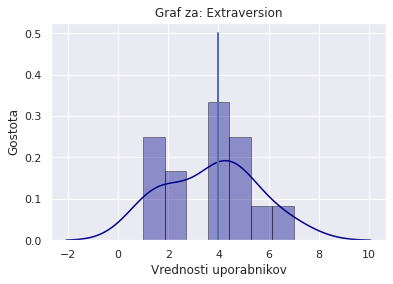

In [8]:
user_bfi_factor(dfLabled, "Extraversion")

Ena izmed osebnostnih lastnosti je ekstravertnost. Ta označuje družabne, ekspresivne in energične posameznike. Nasprotna stran je introvertnost, ki zajema lastnosti kot so zadržanost, samostojnost, molčečnost, itd. Iz zgornje slike lahko opazimo, da je večina uporabnikov nevtralnih, pri čemer pa obstaja nekaj udeležencev, ki so močno introvertni (vrednosti levo od 4 predstavljajo introvertnost).

Median:  3.25


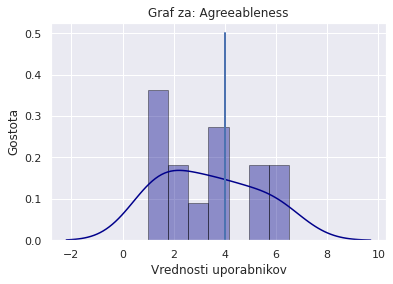

In [9]:
user_bfi_factor(dfLabled, "Agreeableness")

Sprejemljivost opisuje individualne razlike v prijetnosti, prijaznosti in ujemanju v odnosih z drugimi. Pri analizi te lastnosti smo ugotovili, da je ploščina funkcije gostote rahlo večja na levem delu grafa. To nakazuje, da je večina ljudi v raziskavi nagnjena k hitri razburljivosti in nestrinjanju. 

Median:  2.25


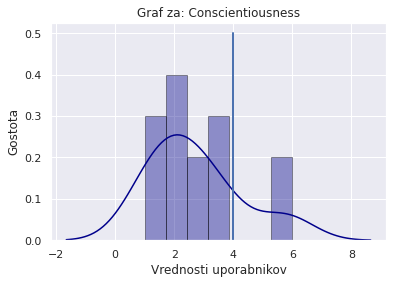

In [10]:
user_bfi_factor(dfLabled, "Conscientiousness")

Vestnost je osebnostna lastnost, ki se nanaša na socialno predpisani vedenjski in kognitivni nadzor samega sebe. Ko jo omenimo govorimo predvsem o odgovornosti, pozornosti, previdnosti in vztrajnosti. Iz zgornjega grafa lahko razberemo, da je večina uporabnikov nizko samodiscipliniranih oziroma nevtralnih. Mediana vestnosti je precej nizka in znaša 2.25. 

Median:  4.25


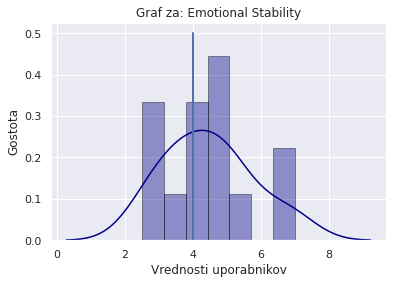

In [11]:
user_bfi_factor(dfLabled, "Emotional Stability")

Zgornji histogram prikazuje porazdelitev za čustveno stabilnost. Rezultati prikazujejo, da so uporabniki v večini čustveno stabilni. Na grafu lahko zaznamo tudi odstopanja. Izkaže se, da se nekateri udeleženci ocenjujejo kot zelo čustveno stabilne oziroma na drugi strani nestabilne. 

Median:  2.25


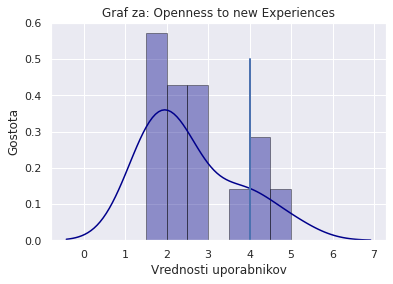

In [12]:
user_bfi_factor(dfLabled, "Openness to new Experiences")

Funkcija gostote nam prikazuje, da je večina ploščine grafa prisotna na levi strani. To napeljuje do sklepa, da so uporabniki aplikacije zelo nagnjeni k zaprtosti. Po analizi podatkov odprtosti lahko trdimo, da udeleženci niso radovedni, domiselni, izvirni in široko misleči oziroma umetniško občutljivi.

V nadaljevanju se bomo usmerili v raziskovanje korelacije med posameznimi osebnostnimi lastnostmi ter napovedovanju končne ocene prikaza oglasa.

### Korelacija matrika osebnostnih lastnosti in ocene

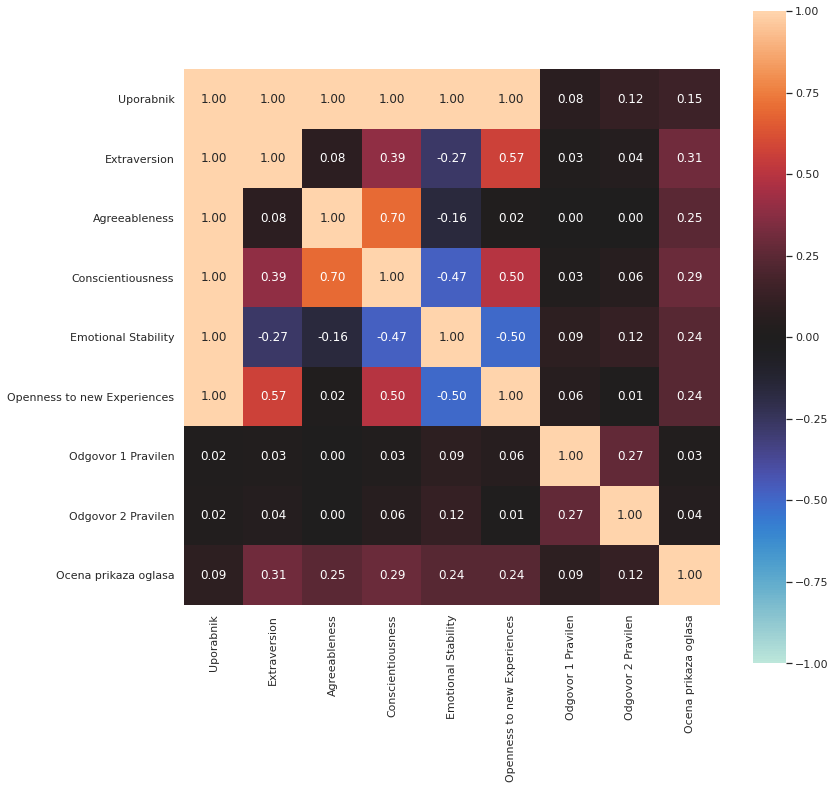

In [16]:
dfTemp = dfLabled.drop(['Starost', 'Spol', 'Ime oglasa', 'Vrsta oglasa', 'Uporabniška aktivnost', 'Nivo baterije', 'Trajanje oglasa', 'Internetna povezava', 'Svetlost zaslona', 'Ura', 'Lokacija'], axis=1)
t = nominal.associations(dfTemp, nominal_columns=["Uporabnik", "Odgovor 1 Pravilen", "Odgovor 2 Pravilen", "Ocena prikaza oglasa"], figsize=(12,12), theil_u=True)

Korelacijska matrika (njeno razumevanje bo predstavljeno v kasnejših poglavjih) nam pokaže, da obstajajo zveze med posameznimi osebnostnimi lastnostmi. Prav tako pa je moč opaziti, da posamezni faktorji osebnostnega testa imajo relacijo z napovedovanjem ocene prikazanega oglasa, saj so njihove absolutne vrednosti večje od 0.

Predhodno smo omenili, da se ocene razlikujejo glede na uporabnike, zato smo želeli še vključiti faktorje osebnostnega testa. Izkaže se, da je večnivojsko-hierarhični linearni model z vključitvijo osebnostnih lastnosti slabši kot če bi samo grupirali po uporabnikih. P-vrednosti posameznih osebnostnih faktorjev so nad 0.05, pri čemer pa so koeficienti premic vsi blizu 0. Z analizo in primerjavo modelov opazimo, da se AIC in BIC povečata kar nam pove, da v nadalnjih modelih ne bomo dosegli boljših rezultatov z vključitvijo osebnostnih lastnosti.

Koda R za primerjavo modelov:

```r
    lmer_users <- lmer(score ~ 1 + (1|user), data=dfFeedback)
    lmer_users_bfi <- lmer(score ~ 1 + extraversion + agreeableness + conscientiousness + 
                           emotional.stability + openness.to.new.experiences + (1|user), data=dfFeedback)

    summary(lmer_users_bfi)
    # Pokaže se, da imajo vse značilke p-vrednost večjo kot 0.05

    anova(lmer_users, lmer_users_bfi)
    # Opazimo, da se AIC in BIC povečata.
    # P-vrednost nam pove, da model z vključitvijo osebnostnih last. ni boljši

    #               npar    AIC    BIC  logLik deviance  Chisq Df Pr(>Chisq)  
    #lmer_users        3 1597.1 1609.8 -795.57   1591.1                       
    #lmer_users_bfi    8 1597.2 1630.9 -790.60   1581.2 9.9379  5    0.07701 .

```

## Pregled in analiza oglasov

In [17]:
def ad_type_analysis(df):
    uniqueAdType = df['Vrsta oglasa'].unique()
    stVseh = len(df['Vrsta oglasa'])    
    data = []
    
    for i, adType in enumerate(uniqueAdType):
        adTypeInput = df.loc[(df['Vrsta oglasa'] == adType)]
        medianS = df['Ocena prikaza oglasa'].median()
        meanS = df['Ocena prikaza oglasa'].mean()
        
        medianS_Type = adTypeInput['Ocena prikaza oglasa'].median()
        meanS__Type = adTypeInput['Ocena prikaza oglasa'].mean()
        
        stTT = len(adTypeInput.loc[(adTypeInput["Odgovor 1 Pravilen"] == True) & (adTypeInput["Odgovor 2 Pravilen"] == True)])
        stFF = len(adTypeInput.loc[(adTypeInput["Odgovor 1 Pravilen"] == False) & (adTypeInput["Odgovor 2 Pravilen"] == False)])
        stFT = len(adTypeInput.loc[(adTypeInput["Odgovor 1 Pravilen"] == False) & (adTypeInput["Odgovor 2 Pravilen"] == True)])
        stTF = len(adTypeInput.loc[(adTypeInput["Odgovor 1 Pravilen"] == True) & (adTypeInput["Odgovor 2 Pravilen"] == False)])

        stOther = stFF+stFT+stTF
        stKomb = stOther + stTT
        
        data.append([adType, len(adTypeInput), len(adTypeInput)/stVseh, meanS, medianS, meanS__Type, medianS_Type, stTT/stKomb, stOther/stKomb ])    
    
    dfAdType = pd.DataFrame(data, columns = ['Ad_Type', '#Ad_Type', '%Ad_Type', 'SMean', 'S_Medain', 'S_Mean_Ad_Type', 'S_Median_Ad_Type', '%Komb. TT', '%Ostale komb.']) 
    return dfAdType

In [18]:
def ad_analysis(df, dfVideoLabled):
    uniqueAds = df['Ime oglasa'].unique()
    stVseh = len(df['Ime oglasa'])    
    dataImg = []
    dataVid = []
    
    for i, adName in enumerate(uniqueAds):
        adNameInput = df.loc[(df['Ime oglasa'] == adName)]
        adType = adNameInput['Vrsta oglasa'].iloc[0]
        medianS = df['Ocena prikaza oglasa'].median()
        meanS = df['Ocena prikaza oglasa'].mean()
        
        medianS_Type = adNameInput['Ocena prikaza oglasa'].median()
        meanS__Type = adNameInput['Ocena prikaza oglasa'].mean()
        
        stTT = len(adNameInput.loc[(adNameInput["Odgovor 1 Pravilen"] == True) & (adNameInput["Odgovor 2 Pravilen"] == True)])
        stFF = len(adNameInput.loc[(adNameInput["Odgovor 1 Pravilen"] == False) & (adNameInput["Odgovor 2 Pravilen"] == False)])
        stFT = len(adNameInput.loc[(adNameInput["Odgovor 1 Pravilen"] == False) & (adNameInput["Odgovor 2 Pravilen"] == True)])
        stTF = len(adNameInput.loc[(adNameInput["Odgovor 1 Pravilen"] == True) & (adNameInput["Odgovor 2 Pravilen"] == False)])

        stOther = stFF+stFT+stTF
        stKomb = stOther + stTT
        
        if adType == 'image':
            avgDuration = adNameInput['Trajanje oglasa'].mean()
            dataImg.append([adName, adType, len(adNameInput), len(adNameInput)/stVseh, avgDuration, meanS, medianS, meanS__Type, medianS_Type, stTT/stKomb, stOther/stKomb ])    
        else:
            procDuration = dfVideoLabled.loc[dfVideoLabled['Ime oglasa'] == adName]['Trajanje oglasa%'].mean()
            dataVid.append([adName, adType, len(adNameInput), len(adNameInput)/stVseh, procDuration, meanS, medianS, meanS__Type, medianS_Type, stTT/stKomb, stOther/stKomb ])    
        
    dfAdTypeImg = pd.DataFrame(dataImg, columns = ['Ad_Name', 'Ad_Type' ,'#Ad_Name', '%Ad_Name', 'Avg. Dur', 'S_Mean', 'S_Medain', 'S_Mean_Ad_Name', 'S_Median_Ad_Name', '%Komb. TT', '%Ostale komb.']) 
    dfAdTypeVid = pd.DataFrame(dataVid, columns = ['Ad_Name', 'Ad_Type' ,'#Ad_Name', '%Ad_Name', '%Avg. Dur', 'S_Mean', 'S_Medain', 'S_Mean_Ad_Name', 'S_Median_Ad_Name', '%Komb. TT', '%Ostale komb.']) 

    return [dfAdTypeImg, dfAdTypeVid]

Iz prejšnjih poglavij smo ugotovili, da so uporabniki različno ocenjevali oglase. Morda se izkaže, da so določene vrste oglasov imele v povprečju boljše ocene kot druge. V nadaljevanju bomo preverili, kako učinkoviti so bili posamezni oglasi in njihove kategorije. 

In [19]:
dfAdType = ad_type_analysis(dfLabled)
dfAdType

,Ad_Type,#Ad_Type,%Ad_Type,SMean,S_Medain,S_Mean_Ad_Type,S_Median_Ad_Type,%Komb. TT,%Ostale komb.
0,image,203,0.405190,0.377246,1.0,0.694581,1.0,0.798030,0.201970
1,vlong,124,0.247505,0.377246,1.0,0.032258,0.0,0.564516,0.435484
2,vshort,174,0.347305,0.377246,1.0,0.252874,0.0,0.718391,0.281609


Iz zgornje tabele lahko razberemo, da obstajajo razlike med posameznimi vrstami oglasov (stolpec S_Mean_Ad_Type). Največ je bilo prikazanih slikovnih oglasov, ki imajo tudi najboljše povprečje izmed vseh vrst oglasov. Najslabše rezultate pa opazimo pri dolgih videih. Zadnja dva stolpca v zgornji tabeli predstavljata procente pravilno odgovorjenih vprašanj, kar pomeni, da je uporabnik iz oglasa pravilno razbral izdelek in njegovo firmo. Rezultati nam pokažejo, da so uporabniki največkrat pravilno odgovorili pri slikovnih oglasih in najmanjkrat pri dolgih videih. To je bilo pričakovano, saj uporabniki potrebujejo nekaj časa, da pri video oglasih razberejo kaj je bilo prikazano. Na tej točki lahko povzamemo, da obstaja opazna razlika med vrstami oglasov. Sedaj bomo še preverili, kako učinkoviti so bili posamezni oglasi.

In [20]:
dfAdName = ad_analysis(dfLabled, dfVideoLabled)

In [21]:
dfAdName[0]

,Ad_Name,Ad_Type,#Ad_Name,%Ad_Name,Avg. Dur,S_Mean,S_Medain,S_Mean_Ad_Name,S_Median_Ad_Name,%Komb. TT,%Ostale komb.
0,18.jpg,image,23,0.045908,10.951696,0.377246,1.0,0.913043,1.0,0.913043,0.086957
1,2.jpg,image,17,0.033932,19.208588,0.377246,1.0,0.588235,1.0,0.882353,0.117647
2,8.jpg,image,17,0.033932,9.998353,0.377246,1.0,0.411765,1.0,0.647059,0.352941
3,4.jpg,image,19,0.037924,12.230842,0.377246,1.0,1.210526,2.0,0.894737,0.105263
4,16.jpg,image,18,0.035928,14.120000,0.377246,1.0,0.222222,0.5,0.722222,0.277778
5,10.jpg,image,17,0.033932,16.297588,0.377246,1.0,0.411765,0.0,0.588235,0.411765
6,14.jpg,image,20,0.039920,24.870300,0.377246,1.0,0.800000,1.0,0.900000,0.100000
7,24.jpg,image,17,0.033932,10.773235,0.377246,1.0,0.823529,1.0,0.882353,0.117647
8,12.jpg,image,17,0.033932,24.540824,0.377246,1.0,1.176471,1.0,0.941176,0.058824
9,22.jpg,image,11,0.021956,15.884182,0.377246,1.0,1.000000,1.0,0.818182,0.181818


Z analizo vseh slikovnih oglasov opazimo, da so udeleženci raziskave podajali večinoma pozitivne ocene (stolpec S_Mean_Ad_Name). Glede na povprečno oceno vseh oglasov vidimo, da so slike močno dvigovale predhodno predstavljeno končno povprečje. V 12. vrstici tabele opazimo, da se skriva oglas, ki je bil veliko slabši kot ostali. Razmerje med kombinacijo pravilno in nepravilno odgovorjenih vprašanj nam nakazuje, da ni nilo pogoste interakcije med udeleženci raziskave in oglasom. To pomeni, da uporabnike vsebina ni zanimala, ali pa niso znali razbrati izdelka oziroma firme. Po kratki analizi oglasa se izkaže, da je njegova vsebina napačno predstavlja izdelek. Pri tem smo tudi ugotovili, da je zastopajoča firma komaj razvidna iz slike. 

Najboljši oglas je imel povprečno oceno enako 1.21. Na njemu je predstavljen avto firme Audi. Tukaj vidimo, da poleg vsebine oglasa ima lahko vpliv tudi razširjenost in priljubljenost firme, ki oglas zastopa.

#### Linearna regresija med trajanjem slikovnega oglasa in oceno prikaza

Radi bi preverili, ali obstaja linearno razmereje med trajanjem slikovnega oglasa in njegovo oceno. Z nekaj vrstic preproste R kode ugotovimo, da trajanje ni statistično relevantno, saj je njegova p-vrednost 0.789, pri čemer pa je korelacijski koeficient skoraj enak 0. Koda:

```r
lm_image_duration <- lm(score ~ duration, data=dfFeedback[dfFeedback$ad.type == "image",])
summary(lm_image_duration) 
(prelim_plot <- ggplot(dfFeedback[dfFeedback$ad.type == "image",], aes(x = duration, y = score)) +
        geom_point() +
        geom_smooth(method = "lm"))
```

![title](img/lm_imageDur.png)

In [22]:
dfAdName[1]

,Ad_Name,Ad_Type,#Ad_Name,%Ad_Name,%Avg. Dur,S_Mean,S_Medain,S_Mean_Ad_Name,S_Median_Ad_Name,%Komb. TT,%Ostale komb.
0,6.mp4,vlong,26,0.051896,0.742306,0.377246,1.0,0.500000,1.0,0.884615,0.115385
1,9.mp4,vlong,31,0.061876,0.568455,0.377246,1.0,0.193548,0.0,0.612903,0.387097
2,11.mp4,vlong,40,0.079840,0.539795,0.377246,1.0,0.200000,0.0,0.825000,0.175000
3,16.mp4,vshort,34,0.067864,0.578088,0.377246,1.0,-0.205882,0.0,0.558824,0.441176
4,4.mp4,vlong,49,0.097804,0.705002,0.377246,1.0,0.367347,1.0,0.673469,0.326531
5,23.mp4,vshort,21,0.041916,0.644679,0.377246,1.0,0.190476,1.0,0.809524,0.190476
6,13.mp4,vlong,31,0.061876,0.675576,0.377246,1.0,-0.032258,0.0,0.548387,0.451613
7,18.mp4,vshort,10,0.019960,0.460034,0.377246,1.0,-1.100000,-1.5,0.000000,1.000000
8,22.mp4,vlong,17,0.033932,0.435131,0.377246,1.0,0.411765,0.0,0.588235,0.411765
9,2.mp4,vshort,32,0.063872,0.633163,0.377246,1.0,0.187500,0.0,0.593750,0.406250


Zgornja tabela prikazuje izpis vseh video oglasov, ki so kratkega (trajanje manjše kot 30 sekund) ali dolgega formata. Hitro opazimo odstopanja pri oceni dolgega video oglasa v 8. vrstici. Povprečna vrednost njegove ocene znaša -1.1. Iz zgornje tabele lahko razberemo, da vrednost ocene kar precej odstopa od ostalih. Če se ozremo na kombinacijo pravilnosti odgovorov opazimo, da noben uporabnik ni pravilno odgovoril na vprašlnik. To pomeni, da je bilo izrazito nezanimanje za predstavljeno vsebino. Po kratki analizi smo hitro ugotovili, da je tematika oglasa zajemala barvanje sten, kar udeležencev ni zanimalo. Poleg vsebine moramo omeniti, da zastopajoča firma ni zelo znana izven Avstralije.
 
Rezultati nam predstavljajo, da je firma, ki je oglas ustvarila, pomemben faktor, poleg same vsebine in dolžine, pri samem ocenjevanju. Z analizo video oglasov opazimo, da so udeleženci v večini bili nevtralni pri ocenjevanju ustreznosti prikaza (stolpec S_mean).

Čeprav nas zanima vpliv konteksta mobilne naprave na ocenjevanje, lahko trdimo, da ima sama vsebina zelo pomemben vpliv na končen rezultat.

#### Linearna regresija med deležem trajanja video oglasa in oceno prikaza

Radi bi preverili, ali obstaja linearno razmereje med deležem trajanja video oglasa (koliko časa je udeleženec gledal video oglas) in njegovo oceno. Z nekaj vrstic preproste R kode ugotovimo, da je trajanje statistično relevantno, saj je njegova p-vrednost enaka 2.35e-10, pri čemer pa je koeficient premice enak 1.2560. Iz predstavljenih rezultatov ugotovimo, da z rastjo deleža trajanja video oglasov dobimo boljše ocene, kar je smiselno, saj bodo uporabniki dlje časa gledali oglas, ker je to v njihovem interesu (morda je vsebina zanimiva, unikatna, predstavljena je zelo znana firma, itd.). Koda:

```r
lm_video_X.Duration <- lm(score ~ X.duration, data=dfVideoFeedback)
summary(lm_video_X.Duration) 
(prelim_plot <- ggplot(lm_video_durationproc, aes(x = X.duration, y = score)) +
        geom_point() +
        geom_smooth(method = "lm"))
```

![title](img/lm_videoXDur.png)

## Pregled in analiza vprašalnika

In [23]:
def meta_data_survey(dfTemp, col):
    dfs = []
    data = []
    
    dfs.append(dfTemp[col])
    kurtosis = dfTemp[col].kurtosis()
    skewness = dfTemp[col].skew(axis = 0, skipna = True)
    stdDev = dfTemp[col].std()
    var = dfTemp[col].std()**2
    modus = dfTemp[col].mode()[0]
    median = dfTemp[col].median()
    mean = dfTemp[col].mean()
    minimum = dfTemp[col].min()
    maximum = dfTemp[col].max()

    data.append([col, kurtosis, skewness, stdDev, var, modus, median, mean, minimum, maximum, abs(minimum - maximum)])
    customDf = pd.DataFrame(data, columns = ["Parameter", "Kurtosis", "Skewness", "Std. Dev.", "Variance", "Modus_S", "Median_S", "Mean_S", "Minimum_S", "Maximum_S", "Range_S"]) 
    
    plt.title('Histogram porazdelitve: ' + col)
    plt.xlabel(col)
    plt.ylabel('Uporabniški vnosi')
    plt.xticks([-2,-1,0,1,2])
    dfTemp[col].plot.hist(grid=True, bins=5, rwidth=0.9, color='#607c8e')
    plt.show()
    
    return customDf

In [24]:
def histogram_vprasanja(q_col1, q_col2, df, cat_y):   
    x = [-2, -1, 0, 1, 2] # Vrednosti ocen
    possible_answers = np.arange(4) # FF, FT, TF, TT kombinacije odgovorov
    index = np.arange(5)
    
    fig, ax = plt.subplots()
    
    ax.set_title('Graf: ' + cat_y)
    ax.set_xlabel('Ocene oglasov')
    ax.set_ylabel('Uporabniški vnosi')
    
    bar_width = (1 / len(possible_answers)) / 1.2
    
    ff_arr = []
    ft_arr = []
    tf_arr = []    
    tt_arr = []
    
    for val in x:
        ff_arr.append(len(df.loc[(df[cat_y] == val) & (df[q_col1] == False) & (df[q_col2] == False)]))
        ft_arr.append(len(df.loc[(df[cat_y] == val) & (df[q_col1] == False) & (df[q_col2] == True)]))
        tf_arr.append(len(df.loc[(df[cat_y] == val) & (df[q_col1] == True) & (df[q_col2] == False)]))
        tt_arr.append(len(df.loc[(df[cat_y] == val) & (df[q_col1] == True) & (df[q_col2] == True)]))
        
    ax.bar(index + 0 * bar_width, ff_arr, bar_width, label="FF")
    ax.bar(index + 1 * bar_width, ft_arr, bar_width, label="FT")
    ax.bar(index + 2 * bar_width, tf_arr, bar_width, label="TF")
    ax.bar(index + 3 * bar_width, tt_arr, bar_width, label="TT")
    
    ax.set_xticks(index + bar_width / len(possible_answers))
    ax.set_xticklabels(x)
    ax.legend()
    
    dfsAnova = []
    
    dfsAnova.append(df.loc[(df[q_col1] == False) & (df[q_col2] == False)][cat_y])
    dfsAnova.append(df.loc[(df[q_col1] == False) & (df[q_col2] == True)][cat_y])
    dfsAnova.append(df.loc[(df[q_col1] == True) & (df[q_col2] == False)][cat_y])
    dfsAnova.append(df.loc[(df[q_col1] == True) & (df[q_col2] == True)][cat_y])
    
    print("Kombinacije odgovorov: ")
    print("False  False: ", ff_arr, "Size: ", sum(ff_arr))
    print("False  True:  ", ft_arr, "Size: ", sum(ft_arr))
    print("True   False: ", tf_arr, "Size: ", sum(tf_arr))
    print("True   True:  ", tt_arr, "Size: ", sum(tt_arr), "\n")

    statistic, pval = stats.f_oneway(*dfsAnova)
    print("P-Value: ", pval, "\n")
    
    if pval > 0.05:
        print("Kombinacije odgovorov niso statistično relevantne.")
    else:
        print("Kombinacije odgovorov so statistično relevantne.")
    
    plt.show()

In [25]:
def histogram_vprasanjaKategorije(q_col1, q_col2, val1, val2, df, cat_y, column, comb):   
    x = [-2, -1, 0, 1, 2] # Vrednosti ocen
    index = np.arange(5)
    
    fig, ax = plt.subplots()
    
    ax.set_title('Graf: ' + cat_y + ' za kombinacijo odgovorov: ' + comb)
    ax.set_xlabel('Ocene oglasov')
    ax.set_ylabel('Uporabniški vnosi')
    
    bar_width = (1 / len(index)) / 1.2
    
    results = []
    data = []
    dataNeg = []
    
    countData = len(df.loc[(df[column] == 'image')])
    countDataNeg = len(df.loc[(df[column] != 'image')])
    
    for val in x:
        data.append(len(df.loc[(df[cat_y] == val) & (df[column] == 'image') & (df[q_col1] == val1) & (df[q_col2] == val2)]))
        dataNeg.append(len(df.loc[(df[cat_y] == val) & (df[column] != 'image') & (df[q_col1] == val1) & (df[q_col2] == val2)]))
    
    ax.bar(index + 0 * bar_width, data, bar_width, label='image')
    ax.bar(index + 1 * bar_width, dataNeg, bar_width, label='video')

    ax.set_xticks(index + bar_width / len(index))
    ax.set_xticklabels(x)
    ax.legend()
                
    dfsAnova = []
    
    dfsAnova.append(df.loc[(df[q_col1] == val1) & (df[q_col2] == val2) & (df[column] == 'image')][cat_y])
    dfsAnova.append(df.loc[(df[q_col1] == val1) & (df[q_col2] == val2) & (df[column] != 'image')][cat_y])
    
    statistic, pval = stats.f_oneway(*dfsAnova)
    print("P-Value: ", pval)
        
    if pval > 0.05:
        print("Kombinacija: ", comb, "ni statistično relevantna.\n")
    else:
        print("Kombinacija: ", comb, "je statistično relevantna.\n")
        
    print("Stevilo vseh vnosov z oznako 'image': ", countData);
    print("Povprecna ocena za kombinacijo", comb, "z oznako image je enaka", sum([x[i]*data[i] for i in range(0,len(data))])/sum(data))
    print("Razmerje " + comb + " z vsemi vnosi z oznako 'image': ", (sum(data)/countData))
    print("")
    print("Stevilo vseh vnosov z oznako 'video': ", countDataNeg);
    print("Povprecna ocena za kombinacijo", comb, "z oznako video je enaka", sum([x[i]*dataNeg[i] for i in range(0,len(dataNeg))])/sum(dataNeg))
    print("Razmerje " + comb + " z vsemi vnosi z oznako 'video': ", (sum(dataNeg)/countDataNeg))
    print("")
        
    plt.show()

Določeni podatki v podatkovni bazi imajo poleg konteksta mobilne naprave še zabeleženo uporabniško interakcijo in izkušnjo. Vprašalnik se je prikazal približno eno sekundo po zaprtju okna z oglasom. Kot je bilo predhodno omenjeno, se je vprašalnik posameznemu uporabniku prikazal največ petkrat na dan. Kasneje je bila ta omejitev odstranjena, saj so udeleženci pokazali večji interes pri odgovarjanju. Vprašalnik je vseboval sledeča tri vprašanja:

1. Kaj je bilo prikazano na oglasu?
2. Katera znamka je zastopala oglas?
3. Ali je bil oglas ustrezno prikazan?

Prvi dve vprašanji sta povezani in merita nivo interakcije uporabnika z oglasom. S tem smo razbrali, če so udeleženci raziskave razumeli vsebino oglasa in so vedeli katera znamka zastopa prikazan izdelek. Zadnje vprašanje zajema ustreznost prikaza oglasa. Odgovor je bil zabeležen z uporabo Likertove lestvice, ki je vsebovala sledeče možnosti:

* Sploh se ne strinjam (vrednost -2)
* Ne strinjam se (vrednost -1)
* Neodločen/a (vrednost 0)
* Strinjam se (vrednost 1)
* Popolnoma se strinjam (vrednost 2)

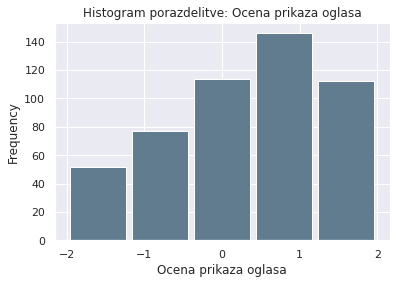

,Parameter,Kurtosis,Skewness,Std. Dev.,Variance,Modus_S,Median_S,Mean_S,Minimum_S,Maximum_S,Range_S
0,Ocena prikaza oglasa,-0.893744,-0.383384,1.270984,1.615401,1,1.0,0.377246,-2,2,4


In [26]:
meta_data_survey(dfLabled, "Ocena prikaza oglasa")

V predhodnem poglavju "Pregled in analiza oglasov" smo podrobno obravnavali ocene oglasov glede na njihovo vsebino in tip. Podatki, vsebovani v zgornji tabeli, nam prikazujejo povzetek ocene vprašalnika in pravijo, da je povprečna ocena oglasov enaka 0.377, pri čemer je najbolj pogosta ocena bila enaka 1. Pri interpretaciji vnosov vidimo, da imamo kar veliko standardno deviacijo. To nam pove, da so uporabniki zelo različno ocenjevali oglase. 

Nadalnja analiza bo posvečena predvsem razumevanju relacij med uporabniško interakcijo in ocenami oglasov. Ker imamo dve vprašanji, je število različnih odgovorov enako štiri, saj udeleženci lahko odgovorijo zgolj pravilno ali napačno.

Kombinacije odgovorov: 
False  False:  [20, 16, 23, 7, 5] Size:  71
False  True:   [2, 10, 12, 8, 5] Size:  37
True   False:  [7, 8, 11, 8, 2] Size:  36
True   True:   [23, 43, 68, 123, 100] Size:  357 

P-Value:  3.3449223178259876e-15 

Kombinacije odgovorov so statistično relevantne.


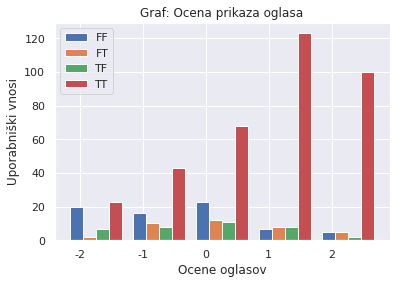

In [27]:
histogram_vprasanja("Odgovor 1 Pravilen", "Odgovor 2 Pravilen", dfLabled, 'Ocena prikaza oglasa')

Graf kombinacij odgovorov nam prikazuje, da so udeleženci raziskave v večini vedeli, kateri izdelek je prikazan na oglasu in katera firma ga zastopa. V primeru, ko vsaj eden izmed odgovorov ni bil pravilen se pokaže, da so uporabniki bili neodločeni, ali pa so podajali negativne ocene. Po izvedbi ANOVA testa ugotovimo, da obstaja statistično relevantna razlika med posameznimi kombinacijami odgovorov, saj je p-vrednost veliko manjša kot 0.05. V nadaljevanju bomo poskusili ugotoviti, ali je vrsta oglasa vplivala pri odgovarjanju na vprašanja.

P-Value:  0.00011575485845881833
Kombinacija:  TT je statistično relevantna.

Stevilo vseh vnosov z oznako 'image':  203
Povprecna ocena za kombinacijo TT z oznako image je enaka 0.9197530864197531
Razmerje TT z vsemi vnosi z oznako 'image':  0.7980295566502463

Stevilo vseh vnosov z oznako 'video':  298
Povprecna ocena za kombinacijo TT z oznako video je enaka 0.4358974358974359
Razmerje TT z vsemi vnosi z oznako 'video':  0.6543624161073825



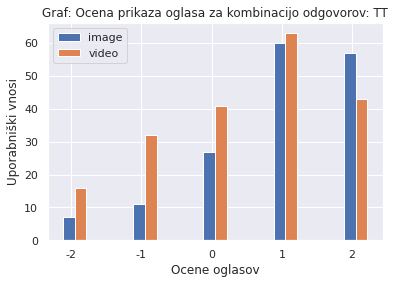

In [28]:
histogram_vprasanjaKategorije("Odgovor 1 Pravilen", "Odgovor 2 Pravilen", True, True, dfLabled, 'Ocena prikaza oglasa', "Vrsta oglasa", "TT")

Zgornji histogram nam prikazuje ocene glede na vrsto prikazanega oglasa, kjer sta oba odgovora bila pravilna. P-vrednost nam pove, da obstajajo statistično relevantne razlike med vrstami oglasov glede na podane uporabniške ocene, ko sta bila oba odgovora pravilna. Iz grafa hitro opazimo, da pride do odstopanj med razmerij slikovnih in video oglasov. Slike so imele 15.4% boljše razmerje, kjer so uporabniki pravilno odgovarjali na obe vprašanji. Rezultat ni tako presenetljiv, saj iz slike lahko hitreje razberemo vsebino. Pri tej kombinaciji odgovorov smo ugotovili, da so slike bile bolj pozitivno ocenjene kot videi.

P-Value:  0.014465707398268335
Kombinacija:  FT je statistično relevantna.

Stevilo vseh vnosov z oznako 'image':  203
Povprecna ocena za kombinacijo FT z oznako image je enaka 0.8888888888888888
Razmerje FT z vsemi vnosi z oznako 'image':  0.04433497536945813

Stevilo vseh vnosov z oznako 'video':  298
Povprecna ocena za kombinacijo FT z oznako video je enaka -0.14285714285714285
Razmerje FT z vsemi vnosi z oznako 'video':  0.09395973154362416



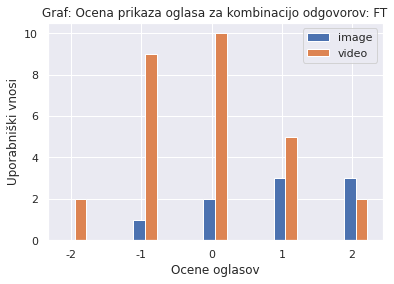

In [29]:
histogram_vprasanjaKategorije("Odgovor 1 Pravilen", "Odgovor 2 Pravilen", False, True, dfLabled, 'Ocena prikaza oglasa', "Vrsta oglasa", "FT")

Pri analizi histograma smo ugotovili, da je zelo majhno število vnosov imelo kombinacijo, kjer udeleženci niso vedeli kateri izdelek je prikazan na oglasu, vendar so vseeno ugotovili firmo, ki ga zastopa. Kljub majhnemu številu takih vnosov vidimo, da video oglasi predvsem zastopajo ocene okoli vrednosti 0. To nam namiguje, da vsebina oglasov ni bila prikazana v pravem trenutku oziroma uporabnikom ni bila všeč njihova vsebina. P-vrednost nam pove, da obstajajo statistično relevantne razlike med vrstami oglasov glede na podane uporabniške ocene, ko je bil prvi odgovor napačen in drug pravilen.

P-Value:  0.4925320522322325
Kombinacija:  TF ni statistično relevantna.

Stevilo vseh vnosov z oznako 'image':  203
Povprecna ocena za kombinacijo TF z oznako image je enaka -0.46153846153846156
Razmerje TF z vsemi vnosi z oznako 'image':  0.06403940886699508

Stevilo vseh vnosov z oznako 'video':  298
Povprecna ocena za kombinacijo TF z oznako video je enaka -0.17391304347826086
Razmerje TF z vsemi vnosi z oznako 'video':  0.07718120805369127



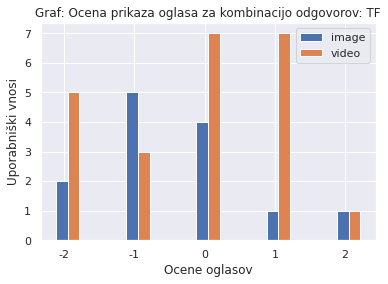

In [30]:
histogram_vprasanjaKategorije("Odgovor 1 Pravilen", "Odgovor 2 Pravilen", True, False, dfLabled, 'Ocena prikaza oglasa', "Vrsta oglasa", "TF")

Po izvedbi statističnega testa ugotovimo, da podatki za kombinacijo pravilnega in nepravilnega odgovora niso statistično relevantni, saj je p-vrednost veliko večja kot 0.05. Vseeno pa lahko opazimo, da glede na prejšnje histograme predvsem izstopajo slikovni oglasi. Izkaže se, da so nekateri udeleženci vedeli kateri izdelek je prikazan na oglasu, vendar pri tem niso razbrali zastopajoče firme. Po podrobni analizi vsebine posameznega slikovnega oglasa se izkaže, da so za določene oglase udeleženci morali intuitivno povezati izdelek s firmo, ki je bila v vprašalniku.

P-Value:  0.9234239783559655
Kombinacija:  FF ni statistično relevantna.

Stevilo vseh vnosov z oznako 'image':  203
Povprecna ocena za kombinacijo FF z oznako image je enaka -0.5263157894736842
Razmerje FF z vsemi vnosi z oznako 'image':  0.09359605911330049

Stevilo vseh vnosov z oznako 'video':  298
Povprecna ocena za kombinacijo FF z oznako video je enaka -0.5576923076923077
Razmerje FF z vsemi vnosi z oznako 'video':  0.174496644295302



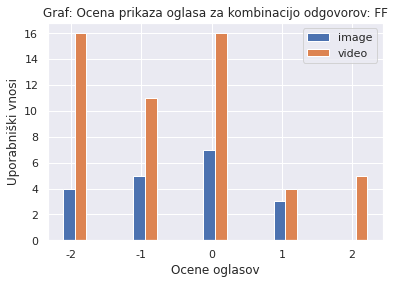

In [31]:
histogram_vprasanjaKategorije("Odgovor 1 Pravilen", "Odgovor 2 Pravilen", False, False, dfLabled, 'Ocena prikaza oglasa', "Vrsta oglasa", "FF")

Po izvedbi statističnega testa ugotovimo, da podatki za kombinacijo dveh napačnih odgovorov niso statistično relevantni, saj je p-vrednost veliko večja kot 0.05. Povprečni oceni oglasov sta bili -0.53 za slikovne in -0.56 za video. Iz histograma tudi razberemo, da je število video oglasov veliko večje kot število slikovnih, ko sta bila oba odgovora napačna.

Analiza vprašalnika nam je pokazala, da je velika večina uporabnikov pravilno odgovarjala na vprašalnik. Video oglasi so bili bolj negativno ocenjeni kot slikovni. Okoli 17% ocenjenih video reklam ima oba odgovora napačna, kar je velik delež prikazanih oglasov znotraj te vrste. Z zaključeno analizo vprašalnika nadaljujemo z razumevanjem vpliva konteksta mobilne naprave na končno oceno prikaza oglasa.

## Pregled in analiza parametrov konteksta

In [32]:
def meta_data(f_name, df, labels, cat_y):
    dfs = []
    data = []
    for i, label in enumerate(labels):
        dfTemp = df.loc[(df[f_name] == label)]
        dfs.append(dfTemp[cat_y])
        kurtosis = dfTemp[cat_y].kurtosis()
        skewness = dfTemp[cat_y].skew(axis = 0, skipna = True)
        stdDev = dfTemp[cat_y].std()
        var = dfTemp[cat_y].std()**2
        modus = dfTemp[cat_y].mode()[0]
        median = dfTemp[cat_y].median()
        mean = dfTemp[cat_y].mean()
        minimum = dfTemp[cat_y].min()
        maximum = dfTemp[cat_y].max()
        
        data.append([label, kurtosis, skewness, stdDev, var, modus, median, mean, minimum, maximum, abs(minimum - maximum)])
    customDf = pd.DataFrame(data, columns = ["Label", "Kurtosis", "Skewness", "Std. Dev.", "Variance", "Modus_S", "Median_S", "Mean_S", "Minimum_S", "Maximum_S", "Range_S"]) 
    statistic, pvalue = stats.levene(*dfs)
    print("LEVENE TEST \n")
    print("P-Value: ", pvalue)
    
    if(pvalue > 0.05):
        print(f_name, "is Homogenous.")
    else:
        print(f_name, "is not Homogenous.")
    
    return customDf

In [33]:
def draw_pie(labels, sizes, desc):
    print(desc)
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90) 
    plt.axis('equal')
    plt.show()

In [34]:
def draw_hist(f_name, labels, df, cat_y):   
    x = [-2, -1, 0, 1, 2]
    index = np.arange(5)
    bar_width = (1 / len(labels)) / 1.2
    
    dfsAnova = []
    
    fig, ax = plt.subplots()
    for i, label in enumerate(labels):
        data = []
        countData = len(df.loc[(df[f_name] == label)])
        print("\nRazmerje za label: ", label)
        dfsAnova.append(df.loc[(df[f_name] == label)][cat_y])
        
        for val in x:
            counter = len(df.loc[(df[cat_y] == val)  & (df[f_name] == label)])
            data.append(counter)
            print("\nRazmerje vnosov za oceno: ", val, " glede na vse vnose za:", label)
            print("Razmerje: ", counter/countData)
        
        print("----------------------------------------------")
        ax.bar(index + i * bar_width, data, bar_width, label=label)
    
    statistic, pval = stats.f_oneway(*dfsAnova)
    print("P-Value: ", pval)
    
    if(pval > 0.05):
        print(f_name, "is not statistically relevant.")
    else:
        print(f_name, "is statistically relevant.")
    
    ax.set_xlabel("Ocene uporabnikov")
    ax.set_ylabel('Uporabniški vnosi')
    ax.set_title('Porazdelitev za ' + f_name + ', glede na '+ cat_y)
    ax.set_xticks(index + bar_width / len(labels))
    ax.set_xticklabels(x)
    ax.legend()
    plt.show()

In [35]:
def draw_boxplot(f_name, labels, df, cat_y):   
    x = [-2, -1, 0, 1, 2] # Vrednosti ocen
    fig, ax = plt.subplots()
    
    ax.set_title('Škatla z brki za '+f_name+', glede na '+ cat_y)
    ax.set_xlabel(f_name)
    ax.set_ylabel('Ocene uporabnikov')
    results = []
                 
    for i, label in enumerate(labels):
        data = []
        
        for val in x:
            s = [val] * len(df.loc[(df[cat_y] == val)  & (df[f_name] == label)])
            if len(s) == 0:
                continue
            
            data = data + s
        results.append(data)

    ax.boxplot(results)
    ax.set_xticklabels(labels)
    plt.show()

In [36]:
def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

In [37]:
def entropy(p):
    return sum(-p[i] * log2(p[i]) for i in range(len(p)))

In [38]:
def kld_analysis(labled, unlabled):
    kld_pq = kl_divergence(labled, unlabled)
    kld_qp = kl_divergence(unlabled, labled)
    
    print("Labled entropy: ", entropy(labled))
    print("Unlabled entropy: ", entropy(unlabled), "\n")
    
    print("Labled || Unlabled KL divergence: ", kld_pq)
    print("Unlabled || Labled KL divergence: ", kld_qp, "\n")

In [39]:
def draw_cont_hist(col, bins, df, desc):
    print(desc, "\n")
    data = []
    kurtosis = df[col].kurtosis()
    skewness = df[col].skew(axis = 0, skipna = True)
    stdDev = df[col].std()
    var = df[col].std()**2
    modus = df[col].mode()[0]
    median = df[col].median()
    mean = df[col].mean()
    maximum = df[col].max()
    minimum = df[col].min()
    
    data.append([col, bins, kurtosis, skewness, stdDev, var, modus, median, mean, minimum, maximum, abs(maximum - minimum)])
    customDf = pd.DataFrame(data, columns = ["Parameter", "#Bins", "Kurtosis", "Skewness", "Std. Dev.", "Variance", "Modus", "Median", "Mean", "Minimum", "Maximum", "Range"])
    
    df[col].plot.hist(grid=True, bins=bins, rwidth=0.9,
                       color='#607c8e')
    
    plt.title('Histogram porazdelitve: ' + col)
    plt.xlabel(col)
    plt.ylabel('Uporabniški vnosi')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    
    return customDf

In [40]:
def draw_cont_func(col, df, desc):
    print(desc)
    df[col].plot.kde()
    
    plt.title('Funkcija, ki opisuje: ' + col)
    plt.xlabel(col)
    plt.ylabel('Normalizirane vrednosti')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [41]:
def draw_cont_boxplot(col, df, desc):
    fig, ax = plt.subplots()
    print(desc)
    ax.set_title('Škatla z brki: '+ col)
    ax.set_xlabel("V")
    ax.set_ylabel(col)
    
    results = []

    for val in df[col]:
        results.append(val)

    ax.boxplot(results)
    plt.show()

In [42]:
def dfColToBins(df, col, bins):
    sizeOfDf = len(df[col])
    minimum = df[col].min()
    maximum = df[col].max()
    rangeBin = abs(minimum - maximum) / bins
    binnedDataProcents = []
    
    for i in range(1, bins+1):
        dfTemp = df.loc[df[col] > minimum]
        dfTemp = dfTemp.loc[df[col] <= (minimum + rangeBin)]
        binnedDataProcents.append(len(dfTemp)/sizeOfDf)
        minimum += rangeBin
    
    return binnedDataProcents

S končano analizo vprašalnika se želimo usmeriti v razumevanje ostalih podatkov, ki smo jih pridobili od uporabnikov. Vsak parameter bo imel predstavljen delež porazdelitve označenih in neoznačenih vnosov, njegov vpliv na končno oceno in odgovor na vprašanje ali je porazdelitev označenih podatkov enaka neoznačenim.

### Uporabniška aktivnost

Ker so podatki bili zbrani v času pandemije koronavirusa, smo imeli majhno število vnosov, ko so bili uporabniki v prevoznih sredstvih. Zaradi tega smo bili prisiljeni opustiti oznako IN_VEHICLE.

In [43]:
STILL_counter_l   = len(dfLabled.loc[(dfLabled['Uporabniška aktivnost'] == 'STILL')])
ON_FOOT_counter_l = len(dfLabled.loc[(dfLabled['Uporabniška aktivnost'] == 'ON_FOOT')])

STILL_counter_ul   = len(dfUnlabled.loc[(dfUnlabled['Uporabniška aktivnost'] == 'STILL')])
ON_FOOT_counter_ul = len(dfUnlabled.loc[(dfUnlabled['Uporabniška aktivnost'] == 'ON_FOOT')])

print('[Labled] Število vnosov z oznako STILL:     ',   STILL_counter_l)
print('[Labled] Število vnosov z oznako ON_FOOT:   ', ON_FOOT_counter_l, "\n")
print('[Unlabled] Število vnosov z oznako STILL:   ',   STILL_counter_ul)
print('[Unlabled] Število vnosov z oznako ON_FOOT: ', ON_FOOT_counter_ul, "\n")

customDf = meta_data('Uporabniška aktivnost', dfLabled, ['STILL', 'ON_FOOT'], 'Ocena prikaza oglasa')
customDf

[Labled] Število vnosov z oznako STILL:      452
[Labled] Število vnosov z oznako ON_FOOT:    49 

[Unlabled] Število vnosov z oznako STILL:    456
[Unlabled] Število vnosov z oznako ON_FOOT:  37 

LEVENE TEST 

P-Value:  0.5091898293270005
Uporabniška aktivnost is Homogenous.


,Label,Kurtosis,Skewness,Std. Dev.,Variance,Modus_S,Median_S,Mean_S,Minimum_S,Maximum_S,Range_S
0,STILL,-0.873240,-0.416646,1.265649,1.601868,1,1.0,0.424779,-2,2,4
1,ON_FOOT,-0.883547,-0.147857,1.248468,1.558673,0,0.0,-0.061224,-2,2,4


Iz tortnega diagrama razberemo, da so v večini uporabniki aplikacijo uporabljali ko so bili pri miru. Ocene znotraj uporabniške aktivnosti so raznolike. Ko je uporabnik bil v fazi mirovanja, je bila povprečna ocena 0.425. Če se je uporabnik gibal opazimo, da so bile ocene bolj nevtralne in se nahajajo pri vrednosti -0.06.

Labled Data: 


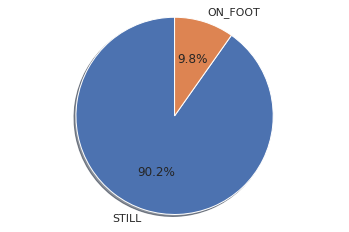

Unlabled Data: 


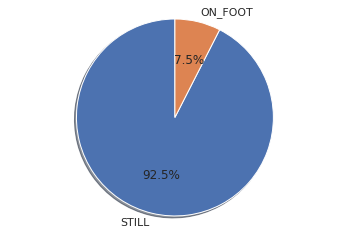

Labled entropy:  0.46199678646205466
Unlabled entropy:  0.38449531510530843 

Labled || Unlabled KL divergence:  0.00494505127657191
Unlabled || Labled KL divergence:  0.004565248691140802 

Histogram prikaza ocen glede na uporabniško aktivnost:


Razmerje za label:  STILL

Razmerje vnosov za oceno:  -2  glede na vse vnose za: STILL
Razmerje:  0.09513274336283185

Razmerje vnosov za oceno:  -1  glede na vse vnose za: STILL
Razmerje:  0.15486725663716813

Razmerje vnosov za oceno:  0  glede na vse vnose za: STILL
Razmerje:  0.2168141592920354

Razmerje vnosov za oceno:  1  glede na vse vnose za: STILL
Razmerje:  0.29646017699115046

Razmerje vnosov za oceno:  2  glede na vse vnose za: STILL
Razmerje:  0.23672566371681417
----------------------------------------------

Razmerje za label:  ON_FOOT

Razmerje vnosov za oceno:  -2  glede na vse vnose za: ON_FOOT
Razmerje:  0.1836734693877551

Razmerje vnosov za oceno:  -1  glede na vse vnose za: ON_FOOT
Razmerje:  0.14285714285714285

Razmer

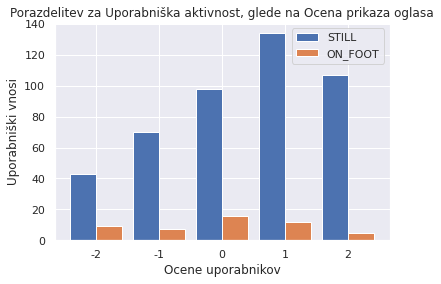

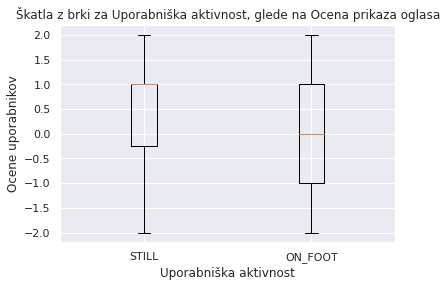

In [41]:
draw_pie(['STILL', 'ON_FOOT'], [STILL_counter_l, ON_FOOT_counter_l], "Labled Data: ")
draw_pie(['STILL', 'ON_FOOT'], [STILL_counter_ul, ON_FOOT_counter_ul], "Unlabled Data: ")
stLabled = STILL_counter_l + ON_FOOT_counter_l
stUnlabled = STILL_counter_ul + ON_FOOT_counter_ul

kld_analysis([STILL_counter_l / stLabled, ON_FOOT_counter_l / stLabled], [STILL_counter_ul / stUnlabled, ON_FOOT_counter_ul / stUnlabled])

print("Histogram prikaza ocen glede na uporabniško aktivnost:\n")
draw_hist('Uporabniška aktivnost', ['STILL', 'ON_FOOT'], dfLabled, 'Ocena prikaza oglasa')
draw_boxplot('Uporabniška aktivnost', ['STILL', 'ON_FOOT'], dfLabled, 'Ocena prikaza oglasa')

P-vrednost nam pokaže, da obstajajo statistično relevantne razlike med mirovanjem in gibanjem. KL divergenca nam pove, da potrebujemo 0.0049 dodatnih bitov informacije za kodiranje neoznačene porazdelitve, pri čemer že poznamo označeno. Procentualna razlika KL divergence in entropije je majhna. Pri analizi uporabniške aktivnosti smo torej ugotovili, da označeni podatki zavzemajo približno enako porazdelitev kot neoznačeni.

### Vrsta internetne povezave

Internetna povezava lahko zavzema vrednosti WIFI ali pa CELLULAR. Spodnji tortni diagram prikazuje porazdelitev vnosov glede na označene in neoznačene podatke. Razmerje med wifi in mobilnimi podatki je skoraj enako. 
Distribuciji označenih in neoznačenih podatkov imata minimalno odstopanje, kar nam KL divergence tudi potrdi. 

In [42]:
WIFI_counter_l   = len(dfLabled.loc[(dfLabled['Internetna povezava'] == 'wifi')])
CELLULAR_counter_l = len(dfLabled.loc[(dfLabled['Internetna povezava'] == 'cellular')])

WIFI_counter_ul   = len(dfUnlabled.loc[(dfUnlabled['Internetna povezava'] == 'wifi')])
CELLULAR_counter_ul = len(dfUnlabled.loc[(dfUnlabled['Internetna povezava'] == 'cellular')])

print('[Labled] Število vnosov z oznako WIFI:       ', WIFI_counter_l)
print('[Labled] Število vnosov z oznako CELLULAR:   ', CELLULAR_counter_l, "\n")
print('[Unlabled] Število vnosov z oznako WIFI:     ', WIFI_counter_ul)
print('[Unlabled] Število vnosov z oznako CELLULAR: ', CELLULAR_counter_ul, "\n")

customDf = meta_data('Internetna povezava', dfLabled, ['wifi', 'cellular'], 'Ocena prikaza oglasa')
customDf

[Labled] Število vnosov z oznako WIFI:        271
[Labled] Število vnosov z oznako CELLULAR:    230 

[Unlabled] Število vnosov z oznako WIFI:      262
[Unlabled] Število vnosov z oznako CELLULAR:  231 

LEVENE TEST 

P-Value:  0.5609943610383004
Internetna povezava is Homogenous.


,Label,Kurtosis,Skewness,Std. Dev.,Variance,Modus_S,Median_S,Mean_S,Minimum_S,Maximum_S,Range_S
0,wifi,-0.936274,-0.434206,1.298110,1.685090,1,1.0,0.446494,-2,2,4
1,cellular,-0.808988,-0.341198,1.236094,1.527929,1,0.0,0.295652,-2,2,4


Iz zgornje tabele lahko razberemo, da je razlika med ocenami z wifijem in podatkovno povezavo enaka 0.15, pri čemer je srednja vrednost obeh enaka 1. Po opravljenem ANOVA testu dobimo p-vrednost, ki je večja kot 0.05, kar pomeni, da ne obstaja statistično relevantna razlika med skupinama.

Labled Data: 


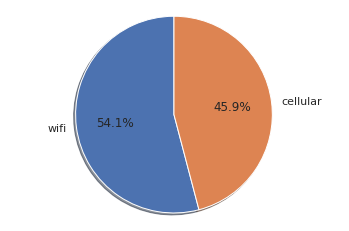

Unlabled Data: 


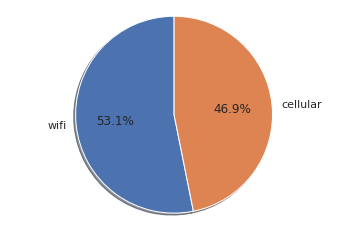

Labled entropy:  0.995163595741904
Unlabled entropy:  0.9971459561143796 

Labled || Unlabled KL divergence:  0.00026045432394717835
Unlabled || Labled KL divergence:  0.0002606938701492107 

Histogram prikaza ocen glede na vrsto internetne povezave:


Razmerje za label:  wifi

Razmerje vnosov za oceno:  -2  glede na vse vnose za: wifi
Razmerje:  0.0996309963099631

Razmerje vnosov za oceno:  -1  glede na vse vnose za: wifi
Razmerje:  0.15867158671586715

Razmerje vnosov za oceno:  0  glede na vse vnose za: wifi
Razmerje:  0.19557195571955718

Razmerje vnosov za oceno:  1  glede na vse vnose za: wifi
Razmerje:  0.2878228782287823

Razmerje vnosov za oceno:  2  glede na vse vnose za: wifi
Razmerje:  0.25830258302583026
----------------------------------------------

Razmerje za label:  cellular

Razmerje vnosov za oceno:  -2  glede na vse vnose za: cellular
Razmerje:  0.10869565217391304

Razmerje vnosov za oceno:  -1  glede na vse vnose za: cellular
Razmerje:  0.14782608695652175

Razm

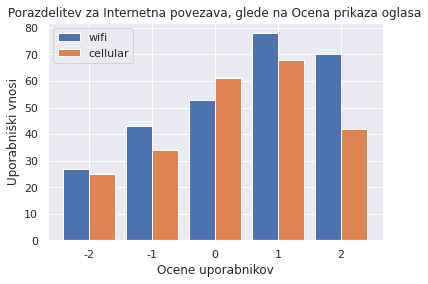

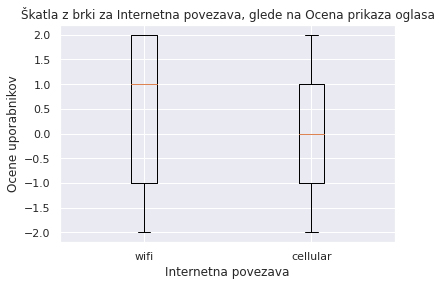

In [43]:
draw_pie(['wifi', 'cellular'], [WIFI_counter_l, CELLULAR_counter_l], "Labled Data: ")
draw_pie(['wifi', 'cellular'], [WIFI_counter_ul, CELLULAR_counter_ul], "Unlabled Data: ")
stLabled = WIFI_counter_l + CELLULAR_counter_l
stUnlabled = WIFI_counter_ul + CELLULAR_counter_ul

kld_analysis([WIFI_counter_l / stLabled, CELLULAR_counter_l / stLabled], [WIFI_counter_ul / stUnlabled, CELLULAR_counter_ul / stUnlabled])

print("Histogram prikaza ocen glede na vrsto internetne povezave:\n")
draw_hist('Internetna povezava', ['wifi', 'cellular'], dfLabled, 'Ocena prikaza oglasa')
draw_boxplot('Internetna povezava', ['wifi', 'cellular'], dfLabled, 'Ocena prikaza oglasa')

### Lokacija uporabnika

Lokacija uporabnika se pretvori iz koordinat v posamezno oznako na dva načina. Ena izmed možnosti je, da v fazi registracije uporabniki zavrnejo avtomatsko učenje iz lokacije in s pomočjo Google Places APIja vnesejo ulico bivanja in dela. Drugi način označevanja lokacije je narejeno s pomočjo periodičnega beleženja koordinat v Androidu. Ko zberemo vsaj 70 točk, se sproži algoritem DBSCAN (angl. Density-based spatial clustering of applications with noise), ki za predhodne oglase z neznano lokacijo posodobi njihove oznake. Zaradi pandemije koronavirusa je bil drugi način označevanja lokacije opuščen, saj ni bilo mogoče določiti delovnega mesta (udeleženci so bili večino časa doma).

In [45]:
HOME_counter_l   = len(dfLabled.loc[(dfLabled['Lokacija'] == 'HOME')])
OTHER_counter_l = len(dfLabled.loc[(dfLabled['Lokacija'] == 'OTHER')])

HOME_counter_ul   = len(dfUnlabled.loc[(dfUnlabled['Lokacija'] == 'HOME')])
OTHER_counter_ul = len(dfUnlabled.loc[(dfUnlabled['Lokacija'] == 'OTHER')])

print('[Labled] Število vnosov z oznako HOME:       ', HOME_counter_l)
print('[Labled] Število vnosov z oznako OTHER:      ', OTHER_counter_l, "\n")
print('[Unlabled] Število vnosov z oznako HOME:     ', HOME_counter_ul)
print('[Unlabled] Število vnosov z oznako OTHER:    ', OTHER_counter_ul, "\n")

customDf = meta_data('Lokacija', dfLabled, ['HOME', 'OTHER'], 'Ocena prikaza oglasa')
customDf

[Labled] Število vnosov z oznako HOME:        142
[Labled] Število vnosov z oznako OTHER:       359 

[Unlabled] Število vnosov z oznako HOME:      160
[Unlabled] Število vnosov z oznako OTHER:     333 

LEVENE TEST 

P-Value:  0.0010981358250848657
Lokacija is not Homogenous.


,Label,Kurtosis,Skewness,Std. Dev.,Variance,Modus_S,Median_S,Mean_S,Minimum_S,Maximum_S,Range_S
0,HOME,-1.372634,-0.089808,1.396462,1.950105,1,0.0,0.119718,-2,2,4
1,OTHER,-0.578119,-0.485646,1.204731,1.451378,1,1.0,0.479109,-2,2,4


Tortni diagram nam pokaže, da je večino oznak bilo označenih z OTHER. Če te podatke povežemo z uporabniško aktivnost opazimo, da pride do velikih odstopanj. V času zbiranja podatkov je bila karantena, kar pomeni da so ljudje bili omejeni pri gibanju in so zato bili večino časa doma. Razmerje med HOME in OTHER nam nakazuje, da velika večina uporabnikov ni imela vklopljene lokacije, ko so aplikacijo uporabljali.

Zgornja tabela nam pokaže, da obstaja majhna razlika v oceni med oznakama HOME in OTHER. Ko ljudje niso bili doma so ocene bile v povprečju 0.48, vendar to nemoremo z gotovostjo trditi, saj je razmerje med oznakama neodraža dejanskega stanja. Po izračunu KL divergene smo opazili, da označeni podatki dobro označujejo neoznačene, saj sta porazdelitvi zelo podobni.

Labled Data: 


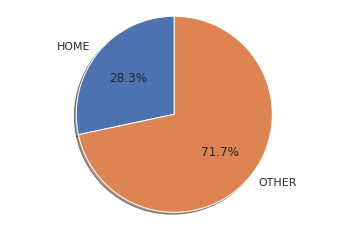

Unlabled Data: 


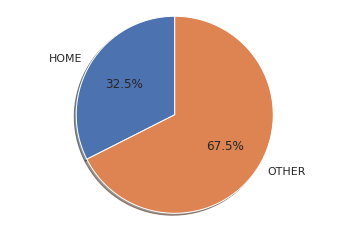

Labled entropy:  0.8600866273027129
Unlabled entropy:  0.9092541986158258 

Labled || Unlabled KL divergence:  0.005695286415341262
Unlabled || Labled KL divergence:  0.005842066417465375 

Histogram prikaza ocen glede na lokacijo uporabnika:


Razmerje za label:  HOME

Razmerje vnosov za oceno:  -2  glede na vse vnose za: HOME
Razmerje:  0.14788732394366197

Razmerje vnosov za oceno:  -1  glede na vse vnose za: HOME
Razmerje:  0.2676056338028169

Razmerje vnosov za oceno:  0  glede na vse vnose za: HOME
Razmerje:  0.1056338028169014

Razmerje vnosov za oceno:  1  glede na vse vnose za: HOME
Razmerje:  0.2746478873239437

Razmerje vnosov za oceno:  2  glede na vse vnose za: HOME
Razmerje:  0.20422535211267606
----------------------------------------------

Razmerje za label:  OTHER

Razmerje vnosov za oceno:  -2  glede na vse vnose za: OTHER
Razmerje:  0.08635097493036212

Razmerje vnosov za oceno:  -1  glede na vse vnose za: OTHER
Razmerje:  0.10863509749303621

Razmerje vnosov za oce

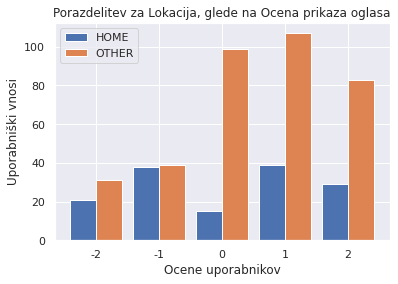

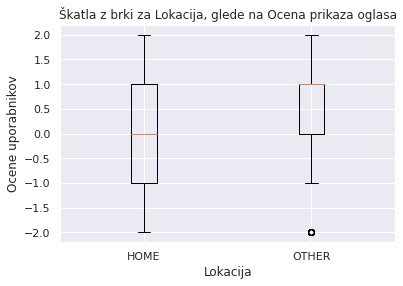

In [46]:
draw_pie(['HOME', 'OTHER'], [HOME_counter_l, OTHER_counter_l], "Labled Data: ")
draw_pie(['HOME', 'OTHER'], [HOME_counter_ul, OTHER_counter_ul], "Unlabled Data: ")
stLabled = HOME_counter_l + OTHER_counter_l
stUnlabled = HOME_counter_ul + OTHER_counter_ul

kld_analysis([HOME_counter_l / stLabled, OTHER_counter_l / stLabled], [HOME_counter_ul / stUnlabled, OTHER_counter_ul / stUnlabled])

print("Histogram prikaza ocen glede na lokacijo uporabnika:\n")
draw_hist('Lokacija', ['HOME', 'OTHER'], dfLabled, 'Ocena prikaza oglasa')
draw_boxplot('Lokacija', ['HOME', 'OTHER'], dfLabled, 'Ocena prikaza oglasa')

### Svetlost zaslona

Kot smo predhodno omenili, vrednosti svetlosti zaslona ležijo na intervalu med 0 in 255. S spodnjega histograma označenih podatkov vidimo, da je največ uporabniških vnosov, ki imajo svetlost okoli 50. Če se ozremo na graf porazdelitvene funkcije vidimo, da je zelo majhno število vrednosti med 150 in 200. Iz analize neoznačenih podatkov ugotovimo, da ima svetlost zaslona najbolj pogosto vrednost pri 58. Z izračunom KL divergence se opazi, da pride do večjih odstopanj, kot pri analizi predhodnjih parametrov konteksta. Čeprav so opazne razlike pri primerjavi distribucij vseeno lahko trdimo, da označeni podatki dobro opisujejo neoznačene.

Labled data:  



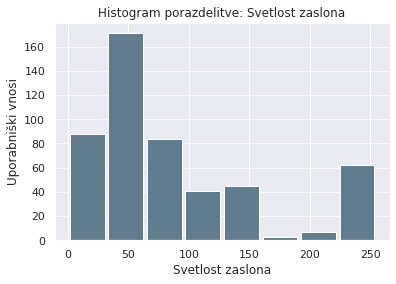

,Parameter,#Bins,Kurtosis,Skewness,Std. Dev.,Variance,Modus,Median,Mean,Minimum,Maximum,Range
0,Svetlost zaslona,8,0.485297,1.233726,72.677579,5282.030491,58,62.0,89.497006,0,255,255


In [46]:
customDf = draw_cont_hist('Svetlost zaslona', 8, dfLabled, "Labled data: ")
customDf

Unlabled data:  



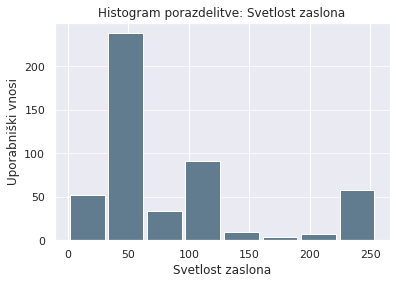

,Parameter,#Bins,Kurtosis,Skewness,Std. Dev.,Variance,Modus,Median,Mean,Minimum,Maximum,Range
0,Svetlost zaslona,8,1.20035,1.492835,69.037688,4766.202394,58,58.0,87.728195,0,255,255


In [47]:
customDf = draw_cont_hist('Svetlost zaslona', 8, dfUnlabled, "Unlabled data: ")
customDf

Labled data: 


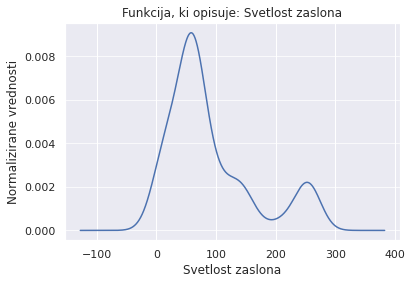

In [48]:
draw_cont_func('Svetlost zaslona', dfLabled, "Labled data: ")

Unlabled data: 


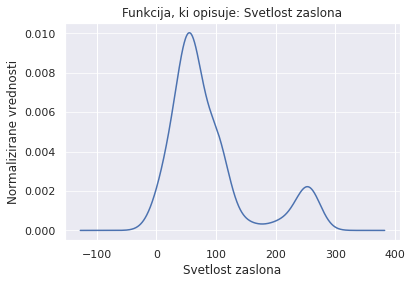

In [49]:
draw_cont_func('Svetlost zaslona', dfUnlabled, "Unlabled data: ")

Labled data: 


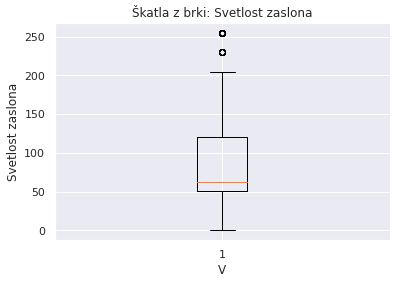

In [50]:
draw_cont_boxplot("Svetlost zaslona", dfLabled, "Labled data: ")

Unlabled data: 


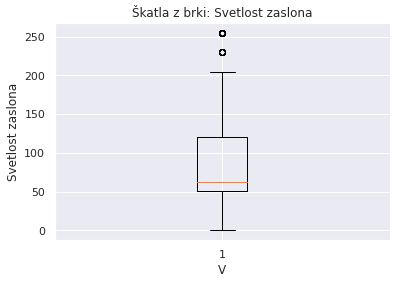

In [51]:
draw_cont_boxplot("Svetlost zaslona", dfLabled, "Unlabled data: ")

In [52]:
labledDist = dfColToBins(dfLabled, "Svetlost zaslona", 8)
unlabledDist = dfColToBins(dfUnlabled, "Svetlost zaslona", 8)

kld_analysis(labledDist, unlabledDist)

Labled entropy:  2.511038531287686
Unlabled entropy:  2.173978278589695 

Labled || Unlabled KL divergence:  0.2904538555015066
Unlabled || Labled KL divergence:  0.24571263885350308 



#### Linearna regresija med svetlostjo zaslona in ocenami oglasa

Radi bi se prepričali ali obstaja povezava med svetlostjo zaslona mobilne naprave in ocenami oglasov, ki so jih uporabniki podajali. Koda, ki smo jo uporabili za izračun korelacije in statistične relavantnosti je sledeča:

```r
lm_brightness <- lm(score ~ brightness, data=dfFeedback)
summary(lm_brightness)
```
Korelacijska matrika, predstavljena v poglavju "Korelacijska matrika med parametri", nam pokaže da obstaja korelacija z oceno prikaza oglasa, vendar je zelo majhna, saj vrednost Pearsonovega koeficienta znaša 0.26. Pravtako pa na podlagi klica funkcije *summary* v jeziku R opazimo, da vrednost koeficienta premice znaša -0.0003967. P-vrednost analiziranega prediktorja (znaša 0.613) nam potrjuje, da ničelna hipoteza velja, kar pomeni da uporabnikova ocena ni odvisna od svetlosti zaslona.

### Nivo baterije

Z analizo nivoja baterije opazimo, da je povprečna vrednost baterije označenih podatkov enaka 0.55 in neoznačenih 0.6. Če se ozremo na porazdelitev podatkov in graf fukcije gostote ugotovimo, da so odstopanja pri distribuciji vnosov označenih in neoznačenih podatkov. Z izračunom KL divergence ugotovimo, da ni večje razlike med predhodno omenjenima distribucijama, zato lahko trdimo, da označeni podatki dobro opisujejo neoznačene.

Labled data:  



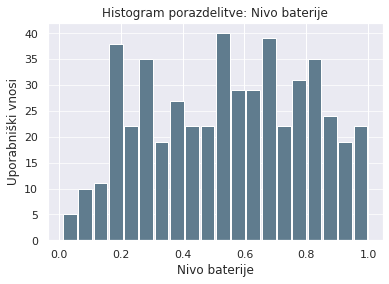

,Parameter,#Bins,Kurtosis,Skewness,Std. Dev.,Variance,Modus,Median,Mean,Minimum,Maximum,Range
0,Nivo baterije,20,-1.083114,-0.108901,0.257344,0.066226,0.6,0.55,0.545828,0.01,1.0,0.99


In [53]:
customDf = draw_cont_hist('Nivo baterije', 20, dfLabled, "Labled data: ")
customDf

Unlabled data:  



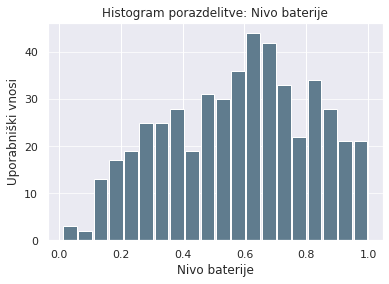

,Parameter,#Bins,Kurtosis,Skewness,Std. Dev.,Variance,Modus,Median,Mean,Minimum,Maximum,Range
0,Nivo baterije,20,-0.863412,-0.182813,0.235465,0.055444,0.66,0.6,0.576653,0.01,1.0,0.99


In [68]:
customDf = draw_cont_hist('Nivo baterije', 20, dfUnlabled, "Unlabled data: ")
customDf

Labled data: 


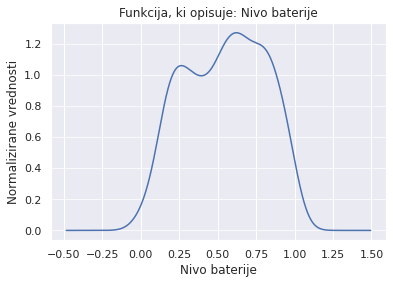

In [55]:
draw_cont_func('Nivo baterije', dfLabled, "Labled data: ")

Unlabled data: 


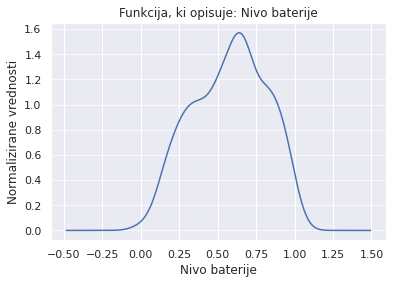

In [56]:
draw_cont_func('Nivo baterije', dfUnlabled, "Unlabled data: ")

Labled data: 


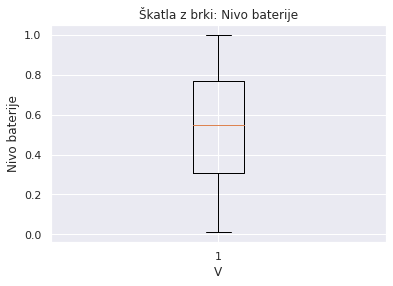

In [57]:
draw_cont_boxplot("Nivo baterije", dfLabled, "Labled data: ")

Unlabled data: 


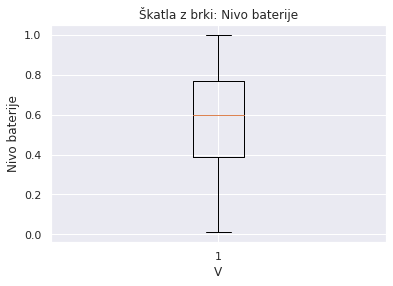

In [58]:
draw_cont_boxplot("Nivo baterije", dfUnlabled, "Unlabled data: ")

In [59]:
labledDist = dfColToBins(dfLabled, "Nivo baterije", 8)
unlabledDist = dfColToBins(dfUnlabled, "Nivo baterije", 8)

kld_analysis(labledDist, unlabledDist)

Labled entropy:  2.887105625482391
Unlabled entropy:  2.827380548526331 

Labled || Unlabled KL divergence:  0.03110822855725439
Unlabled || Labled KL divergence:  0.0409787176023103 



#### Linearna regresija med nivojem baterije in ocenami oglasa

Radi bi se prepričali ali obstaja povezava med nivojem baterije mobilne naprave in ocenami oglasov, ki so jih uporabniki podajali. Koda, ki smo jo uporabili za izračun povezave in statistične relavantnosti je sledeča:

```r
lm_battery <- lm(score ~ battery, data=dfFeedback)
summary(lm_battery)
```

Po analizi rezultatov, ki smo jih pridobili iz funckije *summary* v programskem jeziku R, smo ugotovili, da je p-vrednost 0.00212. S tem smo ničelno hipotezo zavrgli, saj obstaja statistično relevantna razlika pri uporabnikovi oceni, ko jo napovedujemo z nivojem baterije. Koeficient premice znaša 0.6765366, kar pomeni, da so uporabniki z večjim nivojem baterije podajali večje ocene.

### Ura uporabe aplikacije

Pri izpisu histogramov za uro uporabe aplikacije opazimo vidne razlike med distribucijo označenih in neoznačenih podatkov. V primeru označenih podatkov se izkaže, da je aplikacija bila najbolj pogosto uporabljena med 11:00 in 12:00. Če pa se usmerimo na neoznačene podatke pa opazimo, da je aplikacija bila najbolj pogosto uporabljena med 20:00 in 21:00. S spodnjih histogramov smo tudi ugotovili, da so uporabniki najmanj uporabljali aplikacijo med urama 01:00 in 10:00, kar ni tako presenetljivo. Po izračunu KL divergence smo potrdili, da obstaja razlika v distribucijah označenih in neoznačenih podatkov ure uporabe aplikacije.

Labled data:  



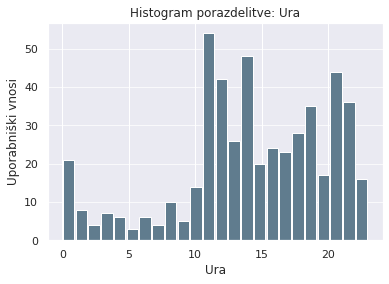

,Parameter,#Bins,Kurtosis,Skewness,Std. Dev.,Variance,Modus,Median,Mean,Minimum,Maximum,Range
0,Ura,24,-0.010201,-0.682761,5.943288,35.322667,11,14.0,14.333333,0,23,23


In [60]:
customDf = draw_cont_hist('Ura', 24, dfLabled, "Labled data: ")
customDf

Unlabled data:  



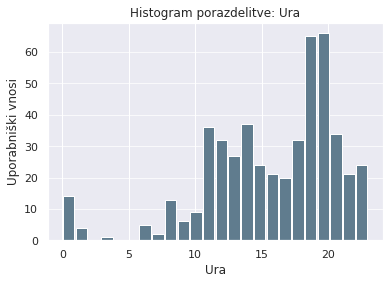

,Parameter,#Bins,Kurtosis,Skewness,Std. Dev.,Variance,Modus,Median,Mean,Minimum,Maximum,Range
0,Ura,24,1.085264,-1.045745,5.171626,26.745716,20,17.0,15.908722,0,23,23


In [61]:
customDf = draw_cont_hist('Ura', 24, dfUnlabled, "Unlabled data: ")
customDf

Labled data: 


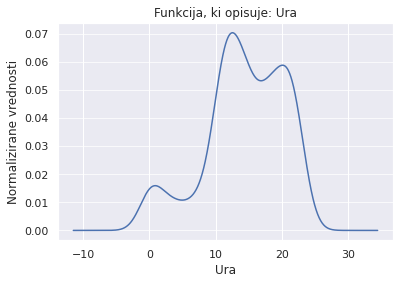

In [62]:
draw_cont_func('Ura', dfLabled, "Labled data: ")

Unlabled data: 


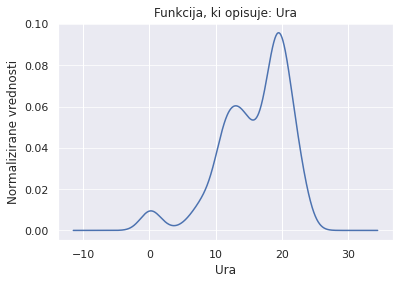

In [63]:
draw_cont_func('Ura', dfUnlabled, "Unlabled data: ")

Labled data: 


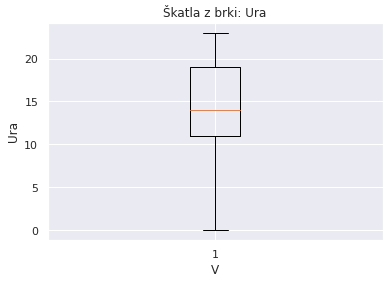

In [64]:
draw_cont_boxplot("Ura", dfLabled, "Labled data: ")

Unlabled data: 


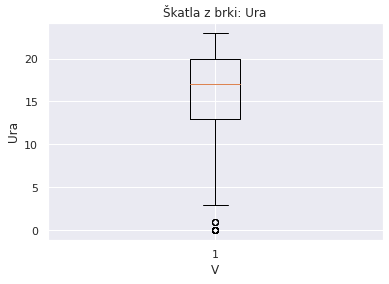

In [65]:
draw_cont_boxplot("Ura", dfUnlabled, "Unlabled data: ")

In [66]:
labledDist = dfColToBins(dfLabled, "Ura", 8)
unlabledDist = dfColToBins(dfUnlabled, "Ura", 8)

kld_analysis(labledDist, unlabledDist)

Labled entropy:  2.6342920901664044
Unlabled entropy:  2.3969242740871985 

Labled || Unlabled KL divergence:  0.17782753434393997
Unlabled || Labled KL divergence:  0.18356992388720017 



#### Linearna regresija med uro uporabe aplikacije in ocenami oglasa

Radi bi se prepričali ali obstaja povezava med uro uporabe aplikacije in ocenami oglasov, ki so jih uporabniki podajali. Koda, ki smo jo uporabili za izračun povezave in statistične relavantnosti je sledeča:

```r
lm_hour <- lm(score ~ hour, data=dfFeedback)
summary(lm_hour)```

Če se ozremo na korelacijsko matriko v poglavju "Korelacijska matrika med parametri" vidimo, da obstaja korelacija med uro uporabe aplikacije in uporabnikovo oceno, vendar je zanemarljivo majhna. P-vrednost zgornjega modela znaša 0.8494, kar nam pove, da ni statistično relevantne korelacije med napovedjo uporabnikove ocene in uro uporabe aplikacije.

## Korelacijska matrika med parametri

Spodnja matrika predstavlja razmerja med posameznimi parametri. Korelacija med dvema zveznima spremenljivkama je bila izračunana z uporabo Pearsonovega koeficienta. Asociacija med dvema nominalnima parametroma je bila ugotovljena s pomočjo Theil’s U statistike, ki je alternativa za Cramér's V statistiko, saj ta ne ohranja simetričnost po diagonali. S tem se izkaže, da so obratne povezave bolj natančno predstavljene. Vsa polja, ki predstavljajo kombinacije zveznih in nominalnih spremenljivk, vsebujejo korelacijsko razmerje. 

Labled data: 


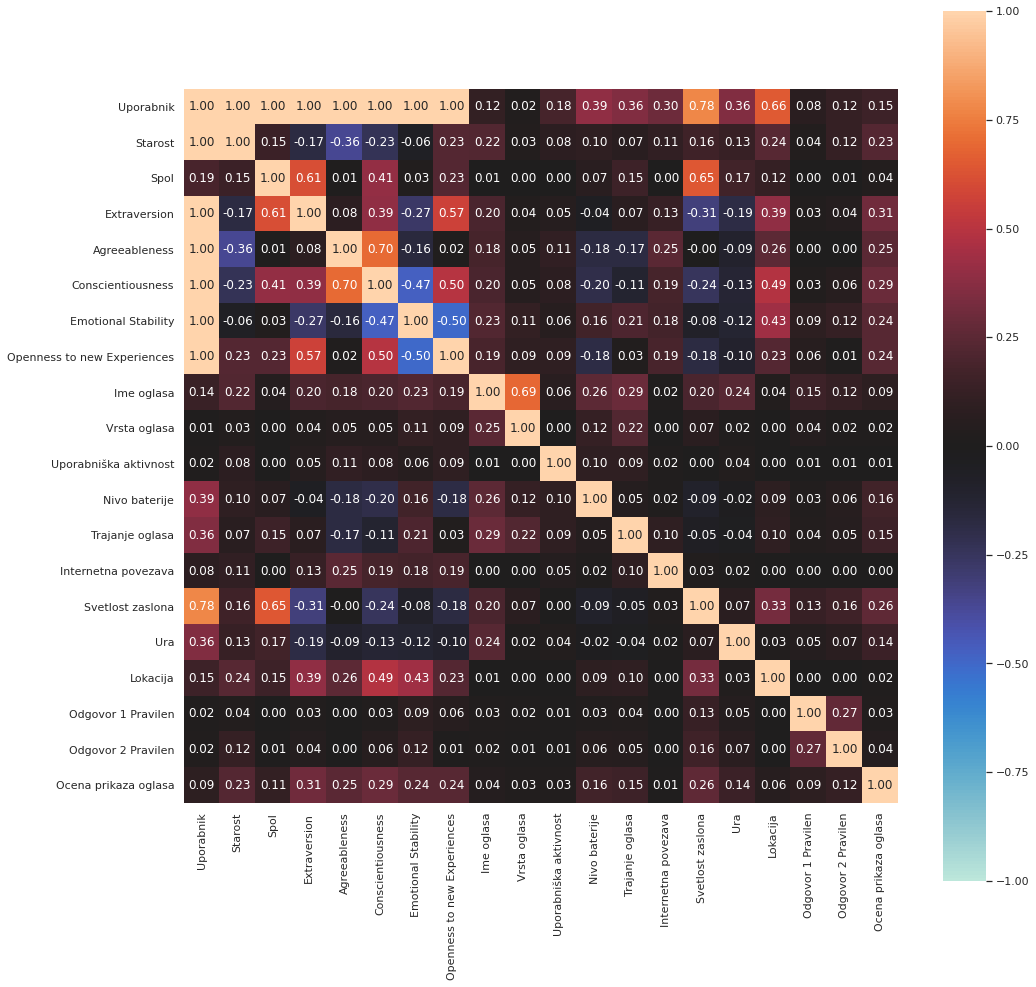

Unlabled data: 


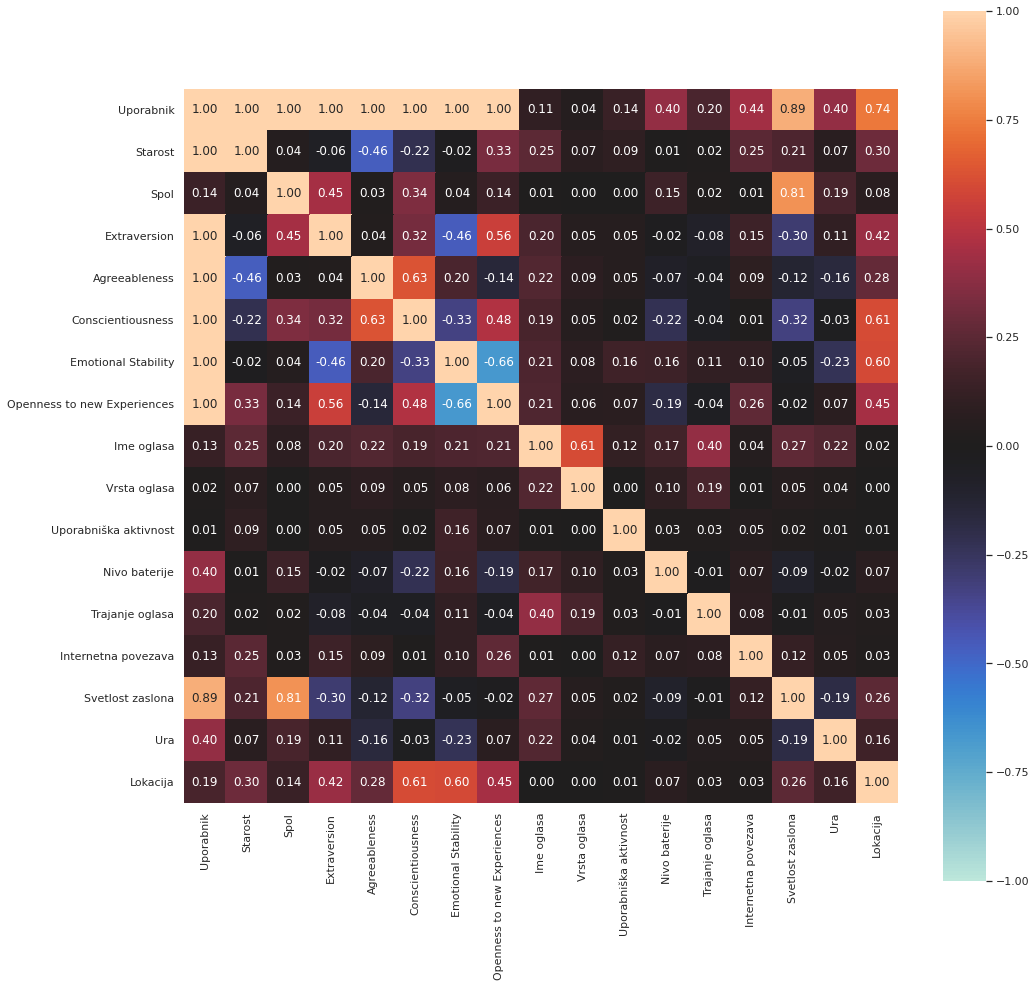

In [47]:
print("Labled data: ")
t = nominal.associations(dfLabled, nominal_columns=["Uporabnik", "Spol", "Ime oglasa", "Vrsta oglasa", "Uporabniška aktivnost", "Internetna povezava", "Lokacija", "Odgovor 1 Pravilen", "Odgovor 2 Pravilen", "Ocena prikaza oglasa"], figsize=(16,16), theil_u=True)

print("Unlabled data: ")
t = nominal.associations(dfUnlabled, nominal_columns=["Uporabnik", "Spol", "Ime oglasa", "Vrsta oglasa", "Uporabniška aktivnost", "Internetna povezava", "Lokacija"], figsize=(16,16), theil_u=True)

Če primerjamo vrednosti korelacij med označenimi in neoznačenimi podatki opazimo, da ni večjih razlik. To smo predhodno potrdili z izračunom KL divergence za določene parametere.

Za interpretacijo razmerja med posameznimi parametri konteksta je bila uporabljena sledeča lestvica:

| Vrednost korelacije                  | Interpretacija                                 |
|--------------------------------------|------------------------------------------------|
| od .90 do 1.00 ali od -.90 do -1.00  | Zelo visoka pozitivna ali negativna korelacija |
| od .70 do .90 ali od -.70 do do -.90 | Visoka pozitivna ali negativna korelacija      |
| od .50 do .70 ali od -.50 do do -.70 | Srednja pozitivna ali negativna korelacija     |
| od .30 do .50 ali od -.30 do do -.50 | Nizka pozitivna ali negativna korelacija       |
| od .00 do .30 ali od .00 do do -.30  | Zanemarljiva korelacija                        |

Link: http://www.parvez-ahammad.org/blog/how-to-interpret-correlation-coefficients

References: 
1. Mukaka, MM. 'A guide to appropriate use of Correlation coefficient in medical research', 2012.
2. Hinkle DE, Wiersma W, Jurs SG. 'Applied Statistics for the Behavioral Sciences', 2003.

Če se usmerimo predvsem v razumevanje zadnjega stolpca opazimo, da so korelacije zanemarljive med posameznimi parametri in oceno uporabnika. To ni presenetljivo, saj so uporabniki oglase subjektivno ocenjevali. V nadaljevanju bomo poskusili zgraditi modele, ki dodatno pojasnjujejo hierarhično strukturo podatkov, saj smo predhodno ugotovili, da obstajajo opazne razlike med posameznimi udeleženci in njihovimi ocenami. 

## Izgradnja večnivojskih modelov

V prejšnjih poglavjih smo večinoma izvajali linearno regresijo, kjer nas je zanimalo kako določen parameter vpliva na napovedovanje ocene prikaza oglasa. Pri tem nismo upoštevali, da so lahko podatki urejeni v smiselnih gručah. Z uporabo večnivojsko-hierarhičnih linearnih modelov se zavedamo obstoja različnih struktur, ki jih določene množice podatkov tvorijo. V poglavju "Pregled in analiza uporabnikov" smo ugotovili, da so podatki bolj smiselno urejeni, če jih grupiramo po uporabnikih. Naše izhodišče torej predstavlja sledeč model:

```r
    lmer_users <- lmer(score ~ 1 + (1|user), data=dfFeedback)
```

V nadaljevanju se bomo osredotočili k raziskavi vpliva posameznih parametrov in njihovih interakcij, pri čemer  gledamo podatke glede na uporabnike. S tem bomo poskusili bolj natančno razložiti, kaj ima pomemben vpliv na napovedovanje končne ocene. 

### Vrsta oglasa

Poskusili smo že dodati osebnostne lastnosti posameznih uporabnikov, vendar se je izkazalo, da je novonastali model slabše pojasnjeval napoved vrednosti uporabnikove ocene. V nadaljevanju bomo v osnoven model vključili vrsto oglasa, saj nas predvsem zanima kakšen vpliv ima njegov tip glede na različne uporabnike.

```r
    lmer_1 <- lmer(score ~ ad.type + (1|user), data=dfFeedback)
```

Če dodamo vrsto oglasa kot "Fixed Effect" opazimo, da model bolj natančno pojasnjuje vpliv podatkov na napoved uporabnikove ocene (AIC in BIC modela se pomanjšata). Pri analizi zgornjega modela smo ugotovili, da so uporabniki v splošnem bolj ocenjevali slikovne oglase (koeficient je enak 0). Predvsem so udeleženci bili kritični do dolgih video oglasov, saj je koeficient premice enak -0.7374. Kratki video oglasi so tudi imeli negativno oceno, saj je njihov koeficient enak -0.445. Ker smo predhodno ugotovili, da se ocene razlikujejo med uporabniki in tipi oglasov, bomo v naš model vključili vrsto reklame kot "Random Slope". S tem bi radi potrdili hipotezo, da obstajajo opazne razlike pri napovedovanju končne ocene, če dovolimo, da se koeficient premice spreminja pri vsakem posamezniku.

```r
    lmer_2 <- lmer(score ~ ad.type + (ad.type|user), data=dfFeedback)
```
Z upoštevanjem možnosti spreminjanja koeficienta premice znotraj posameznega uporabnika glede na vrsto oglasa potrdimo hipotezo, da so posamezni udeleženci raziskave različno ocenjevali vrste oglasov. Pri izpisu koeficientov modela ugotovimo, da so nekateri uporabniki bili zelo kritični pri ocenjevanju dolgih video oglasov. Raznolike začetne vrednosti (interceptov) nam dodatno potrjujejo, da so uporabniki raznoliki. Pri primerjanju obeh modelov se pokaže, da sta se AIC in BIC zelo pomanjšala, če dovolimo variacijo koeficientov premic znotraj vsakega posameznika.

### Vsebina oglasa

Ko smo analizirali posamezne oglase smo opazili, da obstajajo raznolike ocene znotraj vrst oglasov. S spodnjim modelom bomo poskusili ugotoviti, ali lahko uporabimo posamezen oglas pri napovedovanju ocen. 

```r
    lmer_3 <- lmer(score ~ ad.name + (1|user), data=dfFeedback)
```

Ko primerjamo rezultate z osnovnim modelom ugotovimo, da je vsebina posameznega oglasa imela velik vpliv pri končni oceni. Vrednosti AIC in BIC novega modela se pomanjšata, p-vrednost (enaka 5.849e-08) pa nam potrjuje, da obstaja statistično relevantna razlika. Pri klicu funkcije **summary** opazimo, da imajo posamezni oglasi zelo raznolike koeficiente. Ker smo predhodno ugotovili, da vrsta oglasa raznoliko vpliva znotraj posameznih uporabnikov na končno oceno, bomo v model poskusili vključiti vsebino oglasa kot "Random Slope".


```r
    lmer_4 <- lmer(score ~ ad.name + (ad.name|user), data=dfFeedback)
```

Pri izgradnji zgornjega modela naletimo na problem (**boundary (singular) fit: see ?isSingular**). Izkaže se namreč, da ni mogoče zgraditi modela, saj imamo premajhno število podatkov. Če bi želeli raziskati zgornjo relacijo bi vsi udeleženci raziskave morali pogledati vse oglase večkrat.


### Vpliv oglasa in njegove vrste

Predhodno smo ugotovili, da vsebina in vrsta oglasov vpliva pri napovedovanju uporabnikove ocene. Zaradi tega dejstva bomo preverili, ali njuna interakcija bolj pojasnjuje končne ocene posameznikov.

```r
    lmer_5 <- lmer(score ~ ad.name + ad.type + (1|user), data=dfFeedback)
```

Novonastali model je boljši od predhodnjih, kar nam vrednosti AIC in BIC potrdita. Začetna vrednost (intercept) je enaka 0.5346. Pri analizi koeficientov možnih vrednosti prediktorjev opazimo, da so posamezni slikovni oglasi imeli bolj pozitivne vrednosti kot video oglasi. Z gotovostjo lahko tudi trdimo, da je vsebina oglasov imela veliko vlogo pri napovedovanju uporabniških ocen. Pri zgornjem modelu smo tako upoštevali vrsto in vsebino oglasa, pri čemer pa nismo upoštevali, da se uporabniki različno obnašajo. Sedaj bi radi preverili, ali bomo dobili boljše rezultate, če dovolimo, da se lahko ocene vrste oglasa razlikujejo znotraj posameznih uporabnikov.

```r
    lmer_6 <- lmer(score ~ ad.name + ad.type + (ad.type|user), data=dfFeedback)
```

Pri analizi modela smo ugotovili, da so uporabniki res različno ocenjevali vrste oglasov. ANOVA modelov *lmer_5* in *lmer_6* nam pove, da obstaja statistična relevantna razlika med njima, saj je p-vrednost enaka 6.404e-10. Predhodno v modelih nismo upoštevali, da obstaja interakcija med vrsto oglasa in njegovo vsebino. Če želimo strukturo podatkov bolj natančno pojasniti, moramo model malo spremeniti.

```r
    lmer_7 <- lmer(score ~ ad.name * ad.type + (ad.type|user), data=dfFeedback)
```

Z upoštevanjem vpliva vsebine oglasa in njegove vrste ugotovimo sledeče:
    1. interakcija med vsebino in vrsto je pomembna, saj imajo posamezni oglasi različne ocene glede na 
       njihovo vrsto,
    2. posamezni uporabniki so raznoliko ocenjevali vrste oglasov, pri čemer so bili bolj pozitivni 
       do slikovnih in dokaj negativni do dolgih video oglasov,
    3. veliko negativnih ocen opazimo predvsem pri nekaterih dolgih oglasih, kar pomeni, da ima poleg vsebine 
       pomembno vlogo tudi trajanje oglasa
    4. ICC je v osnovnem modelu bil enak 0.17, v zadnjem pa 0.32. To pomeni, da novonastali model boljše
       pojasnjuje strukturo podatkov in njen vpliv na oceno prikaza oglasov. 
       
### Vpliv trajanja oglasov

Predhodno smo zgradili model, ki upošteva interakcijo med vrsto in vsebino oglasa, pri čemer smo dovolili, da se koeficienti premic glede na posameznega uporabnika razlikujejo po tipu reklame. Za vsak vnos v podatkovno bazo smo zabeležili, koliko časa je potekala interakcija med posameznikom in oglasom. Zato bomo v predhodno predstavljen model še vključili trajanje oglasa.
       
```r
    lmer_8 <- lmer(score ~ duration + ad.name * ad.type + (ad.type|user), data=dfFeedback)
```

Rezultati analize nam pokažejo, da trajanje uporabnikove interakcije z oglasom ima pozitiven vpliv na končno oceno, saj je koeficient premice enak 0.015, pri čemer p-vrednost zajema vrednost 2.28e-05. Po klicu funkcije ANOVA(lmer_7, lmer_8) smo ugotovili, da sta se vrednosti AIC in BIC ponovno zmanjšali. P-vrednost opravljenega testa je enaka 1.322e-05, kar nam potrjuje obstoj statistično relevantne razlike med modeloma. S tem smo ugotovili, da dlje časa kot uporabniki preživijo pri gledanju oglasa, boljša bo bila njihova končna ocena prikazanega oglasa. Pri izpisu vrednosti ICC smo ugotovili, da je ta narastla na 0.34.
    
### Uporabniška aktivnost

Z analizo spodnjega modela smo ugotovili, da uporabniška aktivnost ima zelo majhen vpliv pri napovedovanju končne ocene, ki pa je statistično nerelevantna, saj je njegova p-vrednost enaka 0.27. Nad rezultatom nismo preveč začudeni, saj je zbiranje podatkov potekalo v času pandemije koronavirusa (uporabniki so bili večino časa v karanteni, kar pomeni, da smo imeli zelo majhno število vnosovo z oznako ON_FOOT).

```r
    lmer_p1 <- lmer(score ~ activity + (1|user), data=dfFeedback)
```

Po klicu funkcije ANOVA(lmer_users, lmer_p1) ugotovimo, da sta se vrednosti AIC in BIC neznatno povečali. Zaradi te ugotovitve uporabniške aktivnosti v nadaljevanju ne bomo več vključevali.

### Vpliv vrste internetne povezave

Kot smo predhodno omenili so vrednosti internetne povezave lahko označene z WIFI ali CELLULAR. Z vključitvijo novega prediktorja smo ugotovili, da obstaja zelo majhen vpliv med vrsto internetne povezave in oceno prikaza oglasa. Če so uporabniki bili povezani na wifi se je ocena povečala za 0.037, kot pa v primeru podatkovne povezave. P-vrednost je enaka 0.77, kar nam pove, da ne obstaja statistično relevanten vpliv tipa internetne povezave na končno oceno.

```r
    lmer_p2 <- lmer(score ~ internet.type + (1|user), data=dfFeedback)
```

### Upoštevanje lokacije uporabnika

Kot smo predhodno ugotovili, je razmerje med oznakama HOME in OTHER napačno predstavljeno, saj nekateri uporabniki niso imeli vključeno pridobivanje lokacije na mobilni napravi. Z analizo spodnjega modela, kjer smo vključili lokacijo uporabnika, smo ugotovili, da oznaka OTHER daje za 0.1364 bolj pozitivne kot oznaka HOME. Če preverimo p-vrednost pa se pokaže, da ni statistično relevantnega vpliva lokacije uporabnika na oceno prikaza oglasa.

```r
    lmer_p3 <- lmer(score ~ location + (1|user), data=dfFeedback)
```

### Vpliv svetlosti zaslona

Z analizo spodnjega modela smo ugotovili, da ima svetlost zaslona zelo majhen vpliv na končno oceno, saj je koeficient premice enak -3.965e-04. P-vrednost dodanega prediktorja znaša 0.71, kar nam pove, da ni statistično relevantnega vpliva svetlosti zaslona na oceno prikazanega oglasa.

```r
    lmer_p4 <- lmer(score ~ brightness + (1|user), data=dfFeedback)
```

### Vpliv nivoja baterije

Vrednosti baterije se lahko nahajajo na intervalu med 0 in 1. Analiza spodnjega modela nam pokaže, da večji nivoji baterije pozitivno vplivajo na končno oceno (koeficient premice enak 0.4143). Ponovno se izkaže, da dodan prediktor nima statistično relevantnega vpliva, saj je p-vrednost enaka 0.057.

```r
    lmer_p5 <- lmer(score ~ battery + (1|user), data=dfFeedback)
```

### Vpliv ure uporabe aplikacije

Zadnji parameter, ki ga bomo vključili v osnoven model je ura uporabe aplikacije. 

```r
    lmer_p6 <- lmer(score ~ hour + (1|user), data=dfFeedback)
```

Povzetek zgornjega modela nam pove, da obstaja zelo majhen negativen vpliv ure uporabe aplikacije na končno oceno. Koeficient premice znaša -0.001381. Pri analizi p-vrednosti pa ugotovimo, da ni statistično relevantnega vpliva, saj je njena vrednost enaka 0.8822.

### Analiza končnega modela

Gradnjo večnivojsko-hierarhičnih linearnih modelov smo začeli z upoštevanjem grupiranja podatkov po posameznih uporabnikih. Vključitev parametrov, pridobljenih iz testa osebnosti, so se izkazale za neučinkovite. Kakovost modela se s tem ni spremenila. Osebnostne lastnosti se lahko uporabijo za identifikacijo tipa osebe, zato jih bomo vseeno uporabili pri izgradnji napovednih modelov, zgrajene z uporabo strojnega učenja. Ko smo postopoma dodajali parametre konteksta smo opazili, da imajo te statistično nerelevanten vpliv pri napovedovanju končne ocene. 

Končni model, ki najbolje opisuje vpliv podatkov in njihovih struktur na končno oceno uporabnika je sledeč:

```r
    lmer_8 <- lmer(score ~ duration + ad.name * ad.type + (ad.type|user), data=dfFeedback)
```

Sklepe, ki smo jih ugotovili za zgornji model, lahko vidimo v predhodnjih poglavjih, kjer smo posamezne prediktorje postopoma dodajali. Z gradnjo večnivojsko-hierarhičnih linearnih modelov delamo pod predpostavko, da so napake, ki jih model naredi, normalno porazdeljene. V primeru nenormalno porazdeljenih napak se namreč lahko izkaže, da pridemo do napačnega končnega sklepa. Spodnji graf prikazuje porazdelitev napak našega končnega modela:

![title](img/residErrors.png)

Na sliki lahko opazimo, da so napake večinoma normalno porazdeljene, z manjšim odstopanjem v zgornjem delu. Graf nam tako potrjuje, da je naš model ustrezno zgrajen. V nadaljevanju bomo preverili učinkovitost našega modela. Vse ocene, ki imajo vrednost več kot 0.6 bomo označili z 1 (uporabniku je oglas bil všeč), drugače pa jim bomo pripisali vrednost 0 (uporabniku oglas ni bil všeč). Za evaluacijo modela bomo izračunali sledeče metrike:

    * Precision
    * Recall
    * F1 Score
    * Accuracy
    * Mean Accuracy (kFold-10)

Vrednosti, ki smo jih izračunali za naš model, bomo nato primerjali z modelom večinske klasifikacije. Spodnja tabela prikazuje posamezne vrednosti:

|             Metric                   | Dummy Value          | Model Value |
|--------------------------------------|----------------------|-------------|
| Precision                            | 0.49                 | 0.77        | 
| Recall                               | 1.0                  | 0.59        |
| F1                                   | 0.66                 | 0.67        |
| Accuracy                             | 0.49                 | 0.74        |
| Mean Accuracy (kFold-10)             | 0.50                 | 0.70        |

Z uporabo k-kratnega prečnega preverjanja (angl. **k-fold cross-validation**) opazimo, da je naš model imel za 20% večjo natančnost pri napovedovanju, kot večinski klasifikator. Natančnost modelov pa se razlikuje za 25%. Če si pogledamo vrednosti za metriko **recall** opazimo veliko spremembo. V primeru večinskega klasifikatorja imamo vrednost enako 1, saj je model vedno izhod ocenjeval kot pozitiven (število false negativov je enako 0). V našem modelu pa opazimo, da je narastlo število false negativov, kar povzroči spremembo vrednosti iz 1 na 0.59. Na tem mestu trdimo, da je naš model pogosto označil izhod kot negativen, pri čemer pa je v resnici bil pozitiven. Če se usmerimo v analizo vrednosti za metriko **precision** opazimo, da je ta narastla iz 0.49 na 0.77. Spremembo pojasnjujemo tako, da se je število false positivov zmanjšalo, pri čemer pa je narastlo število true positivov. To pomeni, da je naš model pogosto pravilno klasificiral pozitivno oceno. V splošnem se pri izgradnji modelov izkaže, da želimo maksimizirati obe metriki. Metrika **F1** predstavlja harmonično povprečje med **recall** in **precision**. Če se ozremo na primerjavo **F1** vrednosti za večinski klasifikator in naš model opazimo, da je vrednost novonastalega modela narastla za 0.01. Zgornje metrike nam potrjujejo, da večnivojsko-hieararhični linearni model dobro opisuje strukturo podatkov.